# Spatial Image Autocorrelation Analysis

Import necessary files and whatnot. 
$$$$ Remember to adjust the directory and the append path

In [2]:
%matplotlib inline
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf
directory = "Z"
import sys
sys.path.append(directory+":\\Chris\\Code\\DDM\\")
import tiff_file
import ddm_clean as ddm
import io 
import sys
import csv
import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data

# 1) Import
$$$$$$$$
Write the folder name that with your experiment in with this sort of style: Date_concentration type condition
$$$$ Adjust the data_dir with the folder within Anderson lab network as given
$$$$ Lastly, make the data_file equal to the name of the file you would like to analyze (check the printed statements to match what you are analyzing)
$$$$ be sure to adjust the fps and the micron to pixel ratio

In [3]:
"""210904_3.48 MT +0.04XL + 0.7 KN good(J) #graphs done, fits NOT done
210919_100 MT + 0.7 KN good(J) #no zstacks
210919_100 MT good(J)         #no zstacks
210919_4060 AMT + 0.7 KN + 0.47 MY + A-A good(s) #graphs done, fits NOT done
210919_4060 AMT + 0.7 KN + 0.47 MY + MT-MT Good(s) [Aggregate condesning]
210919_4060 AMT + 0.7 KN + A-A good(s)
210919_4060 AMT + 0.7 KN + MT-MT goodish (s) [Aggregate stuff]
210919_4060 AMT + 0.7 KN good(J)
210919_4060 AMT + 0.47 MY + A-A bad
210919_4060 AMT + 0.47 MY + MT-MT good"""

'210904_3.48 MT +0.04XL + 0.7 KN good(J) #graphs done, fits NOT done\n210919_100 MT + 0.7 KN good(J) #no zstacks\n210919_100 MT good(J)         #no zstacks\n210919_4060 AMT + 0.7 KN + 0.47 MY + A-A good(s) #graphs done, fits NOT done\n210919_4060 AMT + 0.7 KN + 0.47 MY + MT-MT Good(s) [Aggregate condesning]\n210919_4060 AMT + 0.7 KN + A-A good(s)\n210919_4060 AMT + 0.7 KN + MT-MT goodish (s) [Aggregate stuff]\n210919_4060 AMT + 0.7 KN good(J)\n210919_4060 AMT + 0.47 MY + A-A bad\n210919_4060 AMT + 0.47 MY + MT-MT good'

In [4]:
typee = "Kinesin\\"   # leave as an empty sting if Confocal videos isn't in a larger folder eg: Kinesin and add \\ at end if it is
exp = "211027_ A-A + kinesin"          #folder name
foldy = ""                                      # leave as an empty sting if not needed
within_rt = ""     # Change to AT for kinesin paper exp
fps = 1
m2p_ratio = 0.8286                         # for microscope it is 0.828 micron to pixel ratio
#data_file = "1_nokinesin_zstack.nd2 - C=1"   #tif file
zstackframes = 5; do_all=0   # change depending on what you want for autocorrelation, minimum 3; do_all: 0=no and 1 = yes
data_dir = directory+":\\Chris\\"+typee+"Confocal Videos\\"+exp+foldy+"\\raw tiffs\\"+within_rt
saveto = directory+":\\Chris\\"+typee+"Confocal Videos\\"+exp+"\\SIA\\"  

files = glob.glob(data_dir+"*min*") 
files.sort()
print("found %i files" % len(files))
for i,f in enumerate(files): print (' %i \t %s' % (i, f.split('\\')[-1]))
    
found_file_number = 3

found 14 files
 0 	 1_410 AA_6min.nd2 - C=0.tif
 1 	 1_410 AA_6min.nd2 - C=1.tif
 2 	 2_417 AA_6min.nd2 - C=0.tif
 3 	 2_417 AA_6min.nd2 - C=1.tif
 4 	 3_424 AA_6min.nd2 - C=0.tif
 5 	 3_424 AA_6min.nd2 - C=1.tif
 6 	 4_431 AA_6min.nd2 - C=0.tif
 7 	 4_431 AA_6min.nd2 - C=1.tif
 8 	 5_439 AA_6min.nd2 - C=0.tif
 9 	 5_439 AA_6min.nd2 - C=1.tif
 10 	 6_447 AA_6min.nd2 - C=0.tif
 11 	 6_447 AA_6min.nd2 - C=1.tif
 12 	 7_456 AA_12min.nd2 - C=0.tif
 13 	 7_456 AA_12min.nd2 - C=1.tif


In [5]:
"""typee = "Kinesin\\"   # leave as an empty sting if Confocal videos isn't in a larger folder eg: Kinesin and add \\ at end if it is
exp = "20200813_5.8 actin 2x myosin"          #folder name
data_file = "6_+488_20min.nd2 - C=0"   #tif file
zstackframes = 5; do_all=0   # change depending on what you want for autocorrelation, minimum 3; do_all: 0=no and 1 = yes
data_dir = directory+":\\Gloria\\"+"Confocal Videos\\"+exp+"\\raw tiffs\\"
saveto = directory+":\\Chris\\"+typee+"Confocal Videos\\"+exp+"\\SIA\\"  
fps = 1   # change this number by the interval of seconds between each frame, Gloria uses .36"""

#found_file_number = 0
full_data_file= files[found_file_number]
data_file = (full_data_file.split('\\')[-1])[:-4]
#print(full_data_file)
#print(data_file)

def find_2nd(string, substring):
    return string.find(substring, string.find(substring) + 1)
def find_1st(string, substring):
    return string.find(substring, string.find(substring))

if fps == .36:
    finame = find_2nd(exp," ")
else: finame = find_1st(exp," ")
gibbb = find_1st(exp,"_")
finalFileLoc = exp[gibbb+1: len(exp):1]
vid_len = 6

index = find_2nd(data_file,"_")
findm = data_file.find("m"); find_hrs = 0; findz = -1; findx = -1
if findm == -1: findh = data_file.find("h"); findm = findh; find_hrs = 1; '''vid_len = -1'''; findz = -1 # why vid len = -1?
if findm == -1 and findh == -1:
    findz = data_file.find("z"); findm = -1; find_hrs = 0; vid_len = -1; findx = -1
    if findz == -1:
        findx = data_file.find("x");findm = -1; find_hrs = 0
    #print("z loc is",findz)
if find_hrs ==1: fps == 10
find_ = exp.find("_")
if findm != -1:
    vid_len = float(data_file[index+1:findm:1])          #Comment out if you want just first 6 min
vid_date = exp[0:find_:1]                     #Remeber to make a folder under each type of exp for date
vid_ti = data_file[0:index:1]
c = data_file[len(data_file)-3:len(data_file):1]
if find_hrs == 1: un = "hrs";
else: 
    if findm == -1:un = "frame"
    else: un = "min"
print(un)
print("This analysis will be in this folder: '" +finalFileLoc+"'")
print("This analysis is of the video of length: '" +str(vid_len)+ "' " + un)
print("This analysis is of the date of the video: '" +vid_date+ "'")

#experiment names
# 1) 20200625_5.8 AMT +myosin_568 actin + 488 mt
# 2) 20200707_5.8 AMT_post contraction

#file names
# 1) 2_first 6min_continuous stimulation.nd2 - C=0
#    2_first 6min_continuous stimulation.nd2 - C=1
#    3_post 4hrs_488 stimulation.nd2 - C=0
#    3_post 4hrs_488 stimulation.nd2 - C=1
#    4_post 6min_continuous stimulation.nd2 - C=0
#    4_post 6min_continuous stimulation.nd2 - C=1
#    5_post  4hrs_no stimulation.nd2 - C=0

# 2) 2_+488_6min.nd2 - C=0
#    2_+488_6min.nd2 - C=1
#    3_561_4hrs.nd2 - C=0
#    5_+488_6min.nd2 - C=0
#    5_+488_6min.nd2 - C=1
#    6_561_4hrs.nd2 - C=0

ims_dat = tiff_file.imread(data_dir+data_file+".tif");
fwee = ims_dat.shape[0]
if do_all == 1: bmw = fwee
else: bmw = zstackframes

min
This analysis will be in this folder: ' A-A + kinesin'
This analysis is of the video of length: '6.0' min
This analysis is of the date of the video: '211027'


Z:\Chris\Spatial Image Analysis\Image-Correlation\tiff_file.py:724: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.vstack((p.asarray() if p else nopage)


Just make sure that the printed key number matches you length of video

In [6]:
ikey = 0
fill = 98
if fps == .36:
    if 6<=vid_len <=11:
        ims = tiff_file.imread(data_dir+data_file+".tif", key=[0,250,500,750,1000]);ikey = 5;delta_f = 1000/fill
    elif vid_len == 1:
        ims = tiff_file.imread(data_dir+data_file+".tif", key=[0]);ikey = 1;delta_f = 1/fill
    elif 15<=vid_len <=18:
        ims = tiff_file.imread(data_dir+data_file+".tif", key=[0,1000,2000]);ikey = 3;delta_f = 2000/fill
    elif 20<=vid_len <=25:
        ims = tiff_file.imread(data_dir+data_file+".tif", key=[0,1000,2000,3000]);ikey = 4;delta_f = 3000/fill
    elif 30<=vid_len <=36:
        ims = tiff_file.imread(data_dir+data_file+".tif", key=[0,1000,2000,3000,4000,5000]);ikey = 6;delta_f = 5000/fill
    elif 42<=vid_len <=47:
        ims = tiff_file.imread(data_dir+data_file+".tif", key=[0,1000,2000,3000,4000,5000,6000,7000]);ikey = 8;delta_f = 7000/fill
if fps == 2.65:
    ims = tiff_file.imread(data_dir+data_file+".tif", key=[0,1]);ikey = 2;delta_f = 1/fill
if fps == 1 or fps == 10:  # or fps == 2.65
    if 1<=vid_len <=2: #min
        ims = tiff_file.imread(data_dir+data_file+".tif", key=[0,17,34]);ikey = 3;delta_f = 34/fill
    #elif vid_len == 9: #min
    #    ims = tiff_file.imread(data_dir+data_file+".tif", key=[0,1,2,3,4,5,6,7,8]);ikey = 9;delta_f = 8/fill
    elif 20<=vid_len <=25: #min
        ims = tiff_file.imread(data_dir+data_file+".tif", key=[0,360,720,1080]);ikey = 4;delta_f = 1080/fill
    elif 30<=vid_len <=35: #min
        ims = tiff_file.imread(data_dir+data_file+".tif", key=[0,300,600,900,1200,1500]);ikey = 6;delta_f = 1500/fill
    elif 42<=vid_len <=47: #min
        ims = tiff_file.imread(data_dir+data_file+".tif", key=[0,360,720,1080,1440,1800,2160,2520]);ikey = 8;delta_f = 2520/fill
    elif 14<=vid_len <=16: #hours
        ims = tiff_file.imread(data_dir+data_file+".tif", key=[0,1000,2000,3000,4000,5000]);ikey = 6;delta_f = 5000/fill
    #elif 5<=vid_len <=8: #hours
     #   ims = tiff_file.imread(data_dir+data_file+".tif", key=[0,360,720,1080,1440,1800]);ikey = 6;delta_f = 1800/fill
    elif vid_len == 40: 
        ims = tiff_file.imread(data_dir+data_file+".tif", key=[0,1,2,3,4]);ikey = 5;delta_f = 4/fill
    elif vid_len == -1 or vid_len == 9:
        fee = []
        if findz == -1: 
            tee = tiff_file.imread(data_dir+data_file+".tif", key=[0]);ikey = -1;delta_f = 4/fill
            ims = np.empty((1,tee.shape[0],tee.shape[1]))
            #print(tee)         If error with tee, make sure it is just a 2D array, if it is not, change image from GBB to grey scale
            for i in range(tee.shape[0]):
                for j in range(tee.shape[1]):
                    ims[0,i,j] = tee[i,j]
            print(ims.shape)
        elif do_all ==1:
            for i in range(bmw):
                fee.append(i)
            ims = tiff_file.imread(data_dir+data_file+".tif", key=fee);ikey = -len(fee);delta_f = fee[-1]/fill
        else: 
            dix = int(fwee/(bmw-1))
            i = 0; 
            while i < fwee:fee.append(i);i=i+dix
        #print(fee)
            ims = tiff_file.imread(data_dir+data_file+".tif", key=fee);ikey = -len(fee);delta_f = fee[-1]/fill
    else: 
        if findm != -1:
            tot_frame = vid_len*60*fps
            if vid_len <= 10:
                increment = int(tot_frame / vid_len);spacer = 1
            elif vid_len > 10 and vid_len < 60:
                increment = int(tot_frame / vid_len * 6); spacer = 6
            fee = []
            for i in range(int(vid_len/spacer)+1):
                fee.append(i*(increment))
            print(fee,tot_frame)
            ims = tiff_file.imread(data_dir+data_file+".tif", key=fee);ikey = int(vid_len/spacer)+1;delta_f = fee[-1]/fill

delta_f = int(delta_f)
print(delta_f)
datapoints = np.zeros(fill+1, dtype=int)
for i in range(fill+1):
    datapoints[i] = i*delta_f
#print(datapoints)
imsdata = tiff_file.imread(data_dir+data_file+".tif", key=datapoints);
print("This will use the " +str(ikey)+ " key")
print("Shape of ims is %i,%i,%i" % ims.shape)
print("So %i frames of %ix%i pixels each" % ims.shape)

[0, 60, 120, 180, 240, 300, 360] 360.0
3
This will use the 7 key
Shape of ims is 7,256,256
So 7 frames of 256x256 pixels each


This simply prints the frames you will be analyzing evenly spaced by six min given by the above code box

7


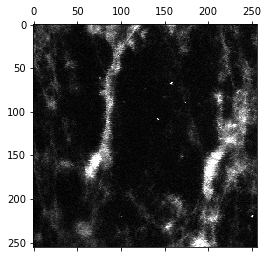

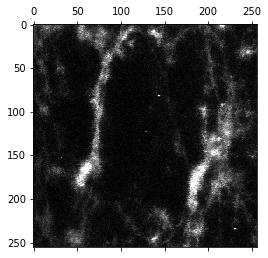

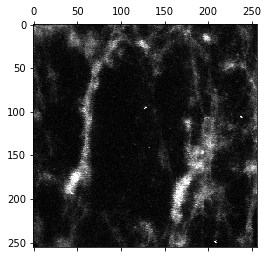

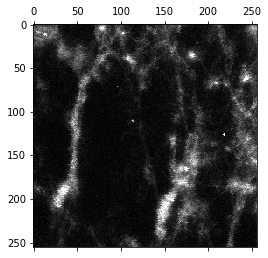

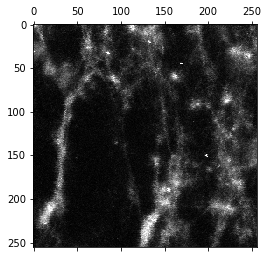

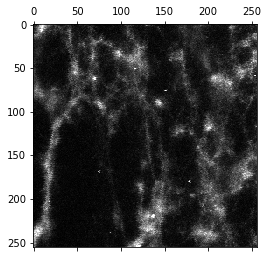

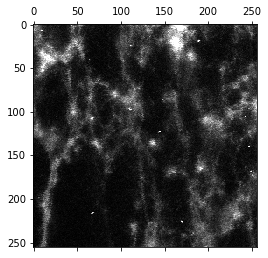

In [7]:
print(len(ims))
if len(ims) > 1: 
    for i in range(len(ims)):
        plt.matshow(ims[i],cmap=cm.gray)
#else: plt.matshow(ims[0],cmap=cm.gray)

Just let the next 5 boxes do their thing as they output the Autocorrelation graph seen at the end of the 5th box

In [8]:
def im_corr(image, filter=False, filtersize=256):
    if filter:
        image = image*1.0 - uf(image,filtersize)
    image = 1.0*image-image.mean()
    image = image/image.std()
    corr_im = abs(fftshift(ifft2(fft2(image)*np.conj(fft2(image)))))/(image.shape[0]*image.shape[1])
    rav_corr = ddm.newRadav(corr_im)
    return corr_im, rav_corr

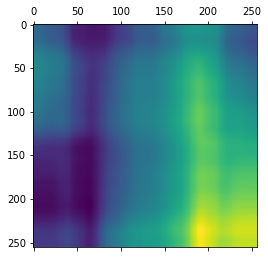

In [9]:
def filtimage(image, filtersize=0):
    image = image*1.0 - uf(image,filtersize)
    return image
#plt.matshow(filtimage(ims[0],filtersize=1000))
#plt.matshow(ims[0])
plt.matshow(ims[0]-filtimage(ims[0],filtersize=256))

In [10]:
corr_ims = np.zeros_like(ims[:,:,:])
corr_ims_dat = np.zeros_like(imsdata[:,:,:])
corr_ravs = np.zeros((ims.shape[0],100))
corr_ravs_dat = np.zeros((imsdata.shape[0],100))
filtersize=256
for i in range(ims.shape[0]):
    corr_ims[i], temp = im_corr(ims[i,:,:], filter=True, filtersize=filtersize)
    corr_ravs[i] = temp[:corr_ravs.shape[1]]
    
#print ((corr_ravs))

In [11]:
for i in range(imsdata.shape[0]):
    corr_ims_dat[i], temp = im_corr(imsdata[i,:,:], filter=True, filtersize=filtersize)
    corr_ravs_dat[i] = temp[:corr_ravs_dat.shape[1]]

7


(-0.04, 1.01)

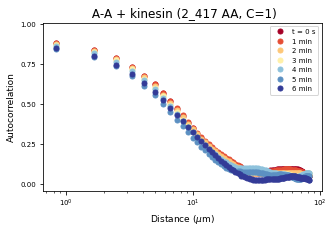

In [12]:
cmap = matplotlib.cm.get_cmap('RdYlBu')

fig, ax = plt.subplots(figsize=(5,5/1.618))
xvalues = np.arange(len(corr_ravs[0])) * m2p_ratio           # VERY IMPORTANT TO ADJUST THIS ABOVE
ax.tick_params(axis='both', which='major', labelsize=7)
if find_hrs == 0:
    if findm == -1:
        zilch = np.linspace(0,200,201); zilch = zilch.astype(int); minut = zilch.astype(str)
    elif vid_len < 12:
        minut = ["0","1","2","3","4","5","6","7","8","9","10","11"]
    else: minut = ["0","6","12","18","24","30","36","42","48"]
elif find_hrs == 1:
    if 14<=vid_len <=16: #hours
        minut = ["0","3","5.5","8","11","14","16.5","19","22"]; contul = "_every_ab_3hrs"
    elif 5<=vid_len <=8: #hours
        minut = ["0","1","2","3","4","5","6","7","8"];contul = "_every_hour"
markerSize = 10
gf1dsize=2
if ikey == 5:
    plt.semilogx(xvalues, gf1d(corr_ravs[0],gf1dsize),'.',ms=markerSize,c=cmap(0),label="t = 0 s")
    plt.plot(xvalues, gf1d(corr_ravs[1],gf1dsize),'.',ms=markerSize,c=cmap(0.25),label='1.5 min')
    plt.plot(xvalues, gf1d(corr_ravs[2],gf1dsize),'.',ms=markerSize,c=cmap(0.4),label='3 min')
    plt.plot(xvalues, gf1d(corr_ravs[3],gf1dsize),'.',ms=markerSize,c=cmap(0.75),label='4.5 min')
    plt.plot(xvalues, gf1d(corr_ravs[4],gf1dsize),'.',ms=markerSize,c=cmap(0.99),label='6 min')
    
if ikey == 3:
    plt.semilogx(xvalues, gf1d(corr_ravs[0],gf1dsize),'.',ms=markerSize,c=cmap(0),label="t = 0 s")
    plt.plot(xvalues, gf1d(corr_ravs[1],gf1dsize),'.',ms=markerSize,c=cmap(0.75),label=minut[1]+" "+un)
    plt.plot(xvalues, gf1d(corr_ravs[2],gf1dsize),'.',ms=markerSize,c=cmap(0.99),label=minut[2]+" "+un)
    
if ikey == 2:
    plt.semilogx(xvalues, gf1d(corr_ravs[0],gf1dsize),'.',ms=markerSize,c=cmap(0),label=minut[0]+" "+un)
    plt.plot(xvalues, gf1d(corr_ravs[1],gf1dsize),'.',ms=markerSize,c=cmap(0.99),label=minut[1]+" "+un)

    
if ikey == 4:
    plt.semilogx(xvalues, gf1d(corr_ravs[0],gf1dsize),'.',ms=markerSize,c=cmap(0),label="t = 0 s")
    plt.plot(xvalues, gf1d(corr_ravs[1],gf1dsize),'.',ms=markerSize,c=cmap(0.25),label=minut[1]+" "+un)
    plt.plot(xvalues, gf1d(corr_ravs[2],gf1dsize),'.',ms=markerSize,c=cmap(0.75),label=minut[2]+" "+un)
    plt.plot(xvalues, gf1d(corr_ravs[3],gf1dsize),'.',ms=markerSize,c=cmap(0.99),label=minut[3]+" "+un)
    
if ikey == 6:
    plt.semilogx(xvalues, gf1d(corr_ravs[0],gf1dsize),'.',ms=markerSize,c=cmap(0),label="t = 0 s")
    plt.plot(xvalues, gf1d(corr_ravs[1],gf1dsize),'.',ms=markerSize,c=cmap(0.25),label=minut[1]+" "+un)
    plt.plot(xvalues, gf1d(corr_ravs[2],gf1dsize),'.',ms=markerSize,c=cmap(0.4),label=minut[2]+" "+un)
    plt.plot(xvalues, gf1d(corr_ravs[3],gf1dsize),'.',ms=markerSize,c=cmap(0.65),label=minut[3]+" "+un)
    plt.plot(xvalues, gf1d(corr_ravs[4],gf1dsize),'.',ms=markerSize,c=cmap(0.75),label=minut[4]+" "+un)
    plt.plot(xvalues, gf1d(corr_ravs[5],gf1dsize),'.',ms=markerSize,c=cmap(0.99),label=minut[5]+" "+un)
    
if ikey == 7:
    plt.semilogx(xvalues, gf1d(corr_ravs[0],gf1dsize),'.',ms=markerSize,c=cmap(0),label="t = 0 s")
    plt.plot(xvalues, gf1d(corr_ravs[1],gf1dsize),'.',ms=markerSize,c=cmap(0.15),label=minut[1]+" "+un)
    plt.plot(xvalues, gf1d(corr_ravs[2],gf1dsize),'.',ms=markerSize,c=cmap(0.35),label=minut[2]+" "+un)
    plt.plot(xvalues, gf1d(corr_ravs[3],gf1dsize),'.',ms=markerSize,c=cmap(0.45),label=minut[3]+" "+un)
    plt.plot(xvalues, gf1d(corr_ravs[4],gf1dsize),'.',ms=markerSize,c=cmap(0.75),label=minut[4]+" "+un)
    plt.plot(xvalues, gf1d(corr_ravs[5],gf1dsize),'.',ms=markerSize,c=cmap(0.85),label=minut[5]+" "+un)
    plt.plot(xvalues, gf1d(corr_ravs[6],gf1dsize),'.',ms=markerSize,c=cmap(0.99),label=minut[6]+" "+un)
    
if ikey == 8:
    plt.semilogx(xvalues, gf1d(corr_ravs[0],gf1dsize),'.',ms=markerSize,c=cmap(0),label="t = 0 s")
    plt.plot(xvalues, gf1d(corr_ravs[1],gf1dsize),'.',ms=markerSize,c=cmap(0.15),label=minut[1]+" "+un)
    plt.plot(xvalues, gf1d(corr_ravs[2],gf1dsize),'.',ms=markerSize,c=cmap(0.35),label=minut[2]+" "+un)
    plt.plot(xvalues, gf1d(corr_ravs[3],gf1dsize),'.',ms=markerSize,c=cmap(0.45),label=minut[3]+" "+un)
    plt.plot(xvalues, gf1d(corr_ravs[4],gf1dsize),'.',ms=markerSize,c=cmap(0.65),label=minut[4]+" "+un)
    plt.plot(xvalues, gf1d(corr_ravs[5],gf1dsize),'.',ms=markerSize,c=cmap(0.75),label=minut[5]+" "+un)
    plt.plot(xvalues, gf1d(corr_ravs[6],gf1dsize),'.',ms=markerSize,c=cmap(0.85),label=minut[6]+" "+un)
    plt.plot(xvalues, gf1d(corr_ravs[7],gf1dsize),'.',ms=markerSize,c=cmap(0.99),label=minut[7]+" "+un)
    
tweet = ims.shape[0]; print(tweet)
'''if ikey > 0:
    for i in range(tweet):
        plt.semilogx(xvalues, gf1d(corr_ravs[i],gf1dsize),'.',ms=markerSize,c=cmap(i/(tweet-.75)),label="case "+str(i+1))
    
if ikey < 0:
    for i in range(tweet):
        plt.semilogx(xvalues, gf1d(corr_ravs[i],gf1dsize),'.',ms=markerSize,c=cmap(i/(tweet-.75)),label="frame "+str(i+1))'''
'''
plt.semilogx(xvalues, gf1d(corr_ravs[0],gf1dsize),'.',ms=markerSize,c=cmap(0),label="t = 0 s")
plt.plot(xvalues, gf1d(corr_ravs[1],gf1dsize),'.',ms=markerSize,c=cmap(0.25),label='1 hr')
plt.plot(xvalues, gf1d(corr_ravs[2],gf1dsize),'.',ms=markerSize,c=cmap(0.4),label='2 hrs')
plt.plot(xvalues, gf1d(corr_ravs[3],gf1dsize),'.',ms=markerSize,c=cmap(0.75),label='3 hrs')
plt.plot(xvalues, gf1d(corr_ravs[4],gf1dsize),'.',ms=markerSize,c=cmap(0.99),label='4 hrs')

    plt.plot(np.exp(-xvalues/2), gf1d(corr_ravs[0],gf1dsize),'.',ms=markerSize,c=cmap(0),label="t = 0 s")
    plt.plot(np.exp(-xvalues/2), gf1d(corr_ravs[1],gf1dsize),'.',ms=markerSize,c=cmap(0.25),label='6 min')
    plt.plot(np.exp(-xvalues/2), gf1d(corr_ravs[2],gf1dsize),'.',ms=markerSize,c=cmap(0.4),label='12 min')
    plt.plot(np.exp(-xvalues/2), gf1d(corr_ravs[3],gf1dsize),'.',ms=markerSize,c=cmap(0.65),label='18 min')
    plt.plot(np.exp(-xvalues/2), gf1d(corr_ravs[4],gf1dsize),'.',ms=markerSize,c=cmap(0.75),label='24 min')
    plt.plot(np.exp(-xvalues/2), gf1d(corr_ravs[5],gf1dsize),'.',ms=markerSize,c=cmap(0.99),label='30 min')
'''
plt.title(finalFileLoc+" ("+vid_ti+", "+c+")")
plt.xlabel("Distance ($\mu$m)",fontsize=9)
plt.ylabel("Autocorrelation",fontsize=9)
plt.legend(loc=0,fontsize=7)
plt.locator_params(axis='y', nbins=5)
plt.ylim(-0.04,1.01)
#plt.xlim(-10,10)

Adjust the place to save the file to and the desired name of the file as needed

In [13]:
length = ""
if ikey == 5:
    length = "_1st_6min"
elif find_hrs==0:
    length = "_every_6min"
else: length = contul



if fps ==.36:  
    fig.savefig(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"
                +finalFileLoc+"\\"+vid_date+"\\"+data_file+"_autocorrelation"+length+".png",dpi=600)
else:
    if findz != -1 or findx != -1: 
        fig.savefig(saveto+"Graphs\\"+data_file+"_autocorrelation"+length+"_"+str(zstackframes)+"frames.png",dpi=600)
    elif vid_len != -1:
        fig.savefig(saveto+"Graphs\\"+data_file+"_autocorrelation"+length+".png",dpi=600)
    else:
        fig.savefig(saveto+"Graphs\\"+data_file+"_autocorrelation"+length+"_totframe_"+str(bmw)+".png",dpi=600)
#plt.savefig(data_file+"_autocorrelation_"+filtersize+".png",dpi=600)
#np.savetxt('//Rae-40TB/AndersonLab-2020/Chris/Confocal Videos/'+exp+'/DDM/'+trial+'/'+filename+'_Final_Data.csv', Final_Data, delimiter=',')

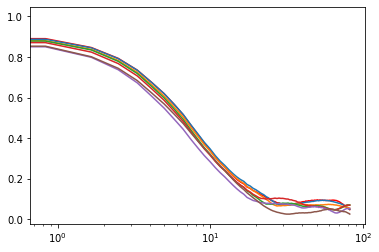

In [14]:
data_vals = np.zeros((corr_ravs.shape[1],corr_ravs.shape[0]+1))
for i in range (len(xvalues)):
    data_vals[i,:] = xvalues[i]
for j in range(1,corr_ravs.shape[0]+1):
    data_vals[:,j] = corr_ravs[j-1,:]
from numpy import asarray
from numpy import savetxt
from numpy import loadtxt

if fps == .36:
    savetxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"
                +finalFileLoc+"\\"+vid_date+"\\"+data_file+"_autocorrelation_data"+length+".csv",data_vals,delimiter=',')
    dataloaded = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"
                +finalFileLoc+"\\"+vid_date+"\\"+data_file+"_autocorrelation_data"+length+'.csv', delimiter=',')
else:
    if findz != 1:
        savetxt(saveto+"Graphs\\"+data_file+"_autocorrelation_data"+length+"_"+str(zstackframes)+"frames.csv",data_vals,delimiter=',')
        dataloaded = loadtxt(saveto+"Graphs\\"+data_file+"_autocorrelation_data"+length+"_"+str(zstackframes)+"frames.csv", delimiter=',')
    else:
        savetxt(saveto+"Graphs\\"+data_file+"_autocorrelation_data"+length+".csv",data_vals,delimiter=',')
        dataloaded = loadtxt(saveto+"Graphs\\"+data_file+"_autocorrelation_data"+length+'.csv', delimiter=',')
plt.figure()
plt.semilogx(dataloaded[:,0],dataloaded[:,1],color='r')
for i in range(2,dataloaded.shape[1]):
    plt.plot(dataloaded[:,0],dataloaded[:,i])
if fps == .36:
    fig.savefig(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"
                +finalFileLoc+"\\"+vid_date+"\\"+data_file+"_autocorrelation_redownloaded"+length+".png",dpi=600)
else: 
    if findz != 1 or findx != -1:
        fig.savefig(saveto+"Graphs\\"+data_file+"_autocorrelation_redownloaded"+length+"_"+str(zstackframes)+"frames.png",dpi=600)
    else: fig.savefig(saveto+"Graphs\\"+data_file+"_autocorrelation_redownloaded"+length+".png",dpi=600)
plt.show()


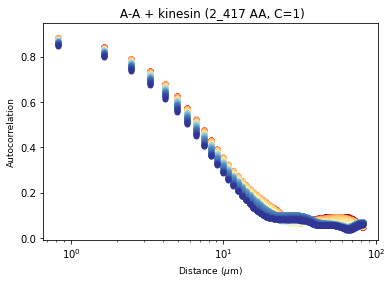

In [15]:
if vid_len != -1:
    x_val_dat = np.arange(len(corr_ravs_dat[0]))*0.828
    fig = plt.figure()
    plt.semilogx(x_val_dat,gf1d(corr_ravs_dat[0],gf1dsize),'.',ms=markerSize,c=cmap(0),label="t = 0 s")
    for i in range(1,corr_ravs_dat.shape[0]):
        plt.plot(x_val_dat, gf1d(corr_ravs_dat[i],gf1dsize),'.',ms=markerSize,c=cmap(i/fill),label=str()+'6 min')
    plt.title(finalFileLoc+" ("+vid_ti+", "+c+")")
    plt.xlabel("Distance ($\mu$m)",fontsize=9)
    plt.ylabel("Autocorrelation",fontsize=9)
    #plt.legend(loc=0,fontsize=7)
    plt.locator_params(axis='y', nbins=5)
    #plt.ylim(-0.04,0.9)
    plt.show()

###### This is for the fitting data saving

In [35]:
if vid_len != -1:
    fig.savefig(saveto+"\\Graphs\\"+data_file+"_autocorrelation_100_1ox"+length+".png",dpi=600)

In [36]:
#x_val_dat = np.arange(len(corr_ravs_dat[0]))*0.828
def chip(chop = 30):
    x_dalues = np.linspace(0,chop,chop+1,dtype=int)
    plt.figure()
    if findz!=-1 or findx!=-1:
        plt.semilogx(xvalues,gf1d(corr_ravs[0],gf1dsize),'.',ms=markerSize,c=cmap(0),label=un + " 0" )
        for i in range(1,corr_ravs.shape[0]):
            plt.plot(xvalues, gf1d(corr_ravs[i],gf1dsize),'.',ms=markerSize,c=cmap(i/(corr_ravs.shape[0]-1)),
                     label=un +" "+ str(i))
    elif findm == -1:
        plt.semilogx(xvalues,gf1d(corr_ravs[0],gf1dsize),'.',ms=markerSize,c=cmap(0),label="t = 0 " + un)
        for i in range(1,corr_ravs.shape[0]):
            plt.plot(xvalues, gf1d(corr_ravs[i],gf1dsize),'.',ms=markerSize,c=cmap(i/(corr_ravs.shape[0]-1)),
                     label=str(i*6)+" "+un)
    else:
        plt.semilogx(xvalues,gf1d(corr_ravs[0],gf1dsize),'.',ms=markerSize,c=cmap(0),label="t = 0 s")
        for i in range(1,corr_ravs.shape[0]):
            plt.plot(xvalues, gf1d(corr_ravs[i],gf1dsize),'.',ms=markerSize,c=cmap(i/(corr_ravs.shape[0]-1)),
                     label=str(i*6)+" min")
    plt.title(finalFileLoc+" ("+vid_ti+", "+c+")")
    plt.xlabel("Distance ($\mu$m)",fontsize=9)
    plt.ylabel("Autocorrelation",fontsize=9)
    plt.legend(loc=0,fontsize=7)
    plt.locator_params(axis='y', nbins=5)
    #plt.ylim(-0.04,0.9)
    plt.show()
    if ikey < 0: ikokay = -ikey
    else: ikokay = ikey
    corr_values = np.zeros((ikokay,len(x_dalues)))
    for i in range(len(x_dalues)):
        corr_values[:,i] = corr_ravs[:,i]
    corr_values = corr_values[:,1:]
    #print(corr_values)
    x_dalues = x_dalues[1:]
    print(x_dalues)
    return x_dalues

In [37]:
'''
data_values = np.zeros((corr_ravs_dat.shape[1],corr_ravs_dat.shape[0]+1))
for i in range (len(x_val_dat)):
    data_values[i,:] = x_val_dat[i]
for j in range(1,corr_ravs_dat.shape[0]+1):
    data_values[:,j] = corr_ravs_dat[j-1,:]
savetxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"
            +finalFileLoc+"\\"+vid_date+"\\"+data_file+"_autocorrelation_data_100"+length+".csv",data_values,delimiter=',')
'''
'''
data_values = np.zeros((corr_values.shape[1],corr_values.shape[0]+1))
for i in range (chop):
    data_values[i,:] = x_dalues[i]
for j in range(1,corr_values.shape[0]+1):
    data_values[:,j] = corr_values[j-1,:]
#savetxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
            #+finalFileLoc+"\\"+vid_date+"\\"+data_file+"_autocorrelation_data_"+str(chop)+length+".csv",data_values,delimiter=',')
'''

'\ndata_values = np.zeros((corr_values.shape[1],corr_values.shape[0]+1))\nfor i in range (chop):\n    data_values[i,:] = x_dalues[i]\nfor j in range(1,corr_values.shape[0]+1):\n    data_values[:,j] = corr_values[j-1,:]\n#savetxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"\n            #+finalFileLoc+"\\"+vid_date+"\\"+data_file+"_autocorrelation_data_"+str(chop)+length+".csv",data_values,delimiter=\',\')\n'

In [38]:
'''
# Exponential fitting
A = 0.07827
plt.figure()
plt.semilogx(xvalues,gf1d(corr_ravs[0],gf1dsize),'.',ms=markerSize,c=cmap(0),label="t = 0 s")
for i in range(1,corr_ravs.shape[0]):
    plt.plot(xvalues, gf1d(corr_ravs[i],gf1dsize),'.',ms=markerSize,c=cmap(i/(corr_ravs.shape[0]-1)),
             label=str(i*6)+' min')
for i in range(corr_ravs.shape[0]):
    plt.plot(x_dalues,np.exp(data_values[:,i]/A),'-',ms=markerSize,c=cmap(1-i/(corr_ravs.shape[0]-1)),
             label=str(i*6)+' min')
plt.show()

# power fitting 
A = 0.24702833333333
B = -0.025853333333333
C = 0.61412833333333

plt.figure()
plt.plot(xvalues,gf1d(corr_ravs[0],gf1dsize),'.',ms=markerSize,c=cmap(0),label="t = 0 s")
for i in range(1,corr_ravs.shape[0]):
    plt.plot(xvalues, gf1d(corr_ravs[i],gf1dsize),'.',ms=markerSize,c=cmap(i/(corr_ravs.shape[0]-1)),
             label=str(i*6)+' min')
for i in range(corr_ravs.shape[0]):
    plt.plot(x_dalues,A/data_values[:,i]**C + B,'-',ms=markerSize,c=cmap(i/(corr_ravs.shape[0]-1)),
             label=str(i*6)+' min')
plt.show()
'''

'\n# Exponential fitting\nA = 0.07827\nplt.figure()\nplt.semilogx(xvalues,gf1d(corr_ravs[0],gf1dsize),\'.\',ms=markerSize,c=cmap(0),label="t = 0 s")\nfor i in range(1,corr_ravs.shape[0]):\n    plt.plot(xvalues, gf1d(corr_ravs[i],gf1dsize),\'.\',ms=markerSize,c=cmap(i/(corr_ravs.shape[0]-1)),\n             label=str(i*6)+\' min\')\nfor i in range(corr_ravs.shape[0]):\n    plt.plot(x_dalues,np.exp(data_values[:,i]/A),\'-\',ms=markerSize,c=cmap(1-i/(corr_ravs.shape[0]-1)),\n             label=str(i*6)+\' min\')\nplt.show()\n\n# power fitting \nA = 0.24702833333333\nB = -0.025853333333333\nC = 0.61412833333333\n\nplt.figure()\nplt.plot(xvalues,gf1d(corr_ravs[0],gf1dsize),\'.\',ms=markerSize,c=cmap(0),label="t = 0 s")\nfor i in range(1,corr_ravs.shape[0]):\n    plt.plot(xvalues, gf1d(corr_ravs[i],gf1dsize),\'.\',ms=markerSize,c=cmap(i/(corr_ravs.shape[0]-1)),\n             label=str(i*6)+\' min\')\nfor i in range(corr_ravs.shape[0]):\n    plt.plot(x_dalues,A/data_values[:,i]**C + B,\'-\',ms

<ipython-input-39-7b5bb790df42>:31: RuntimeWarning: divide by zero encountered in power
  return (A)*(t)**(C)
<ipython-input-39-7b5bb790df42>:31: RuntimeWarning: divide by zero encountered in power
  return (A)*(t)**(C)


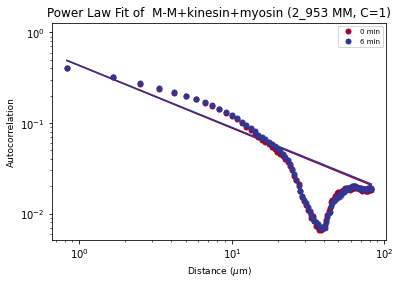

No handles with labels found to put in legend.


[0, 0]


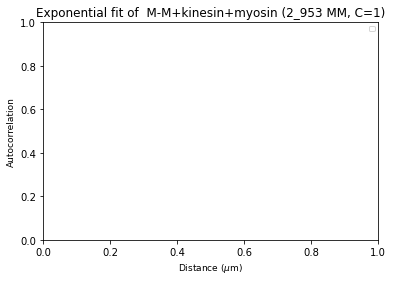

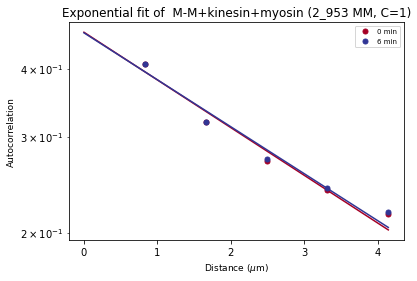

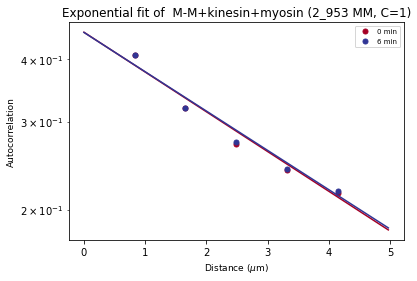

No handles with labels found to put in legend.


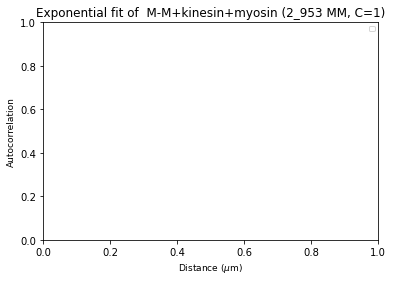

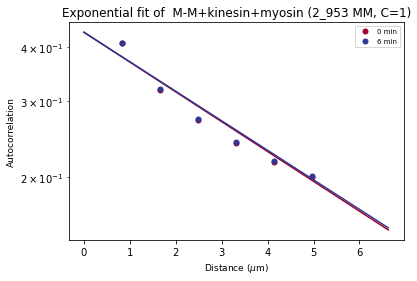

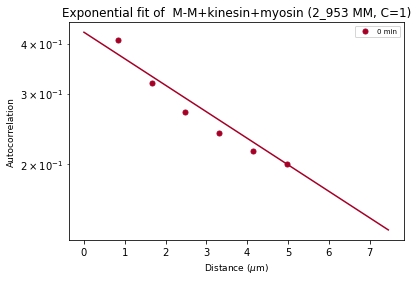

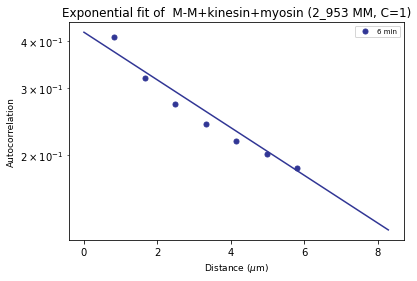

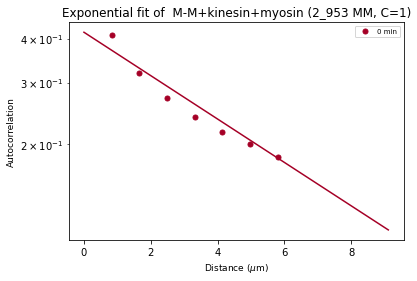

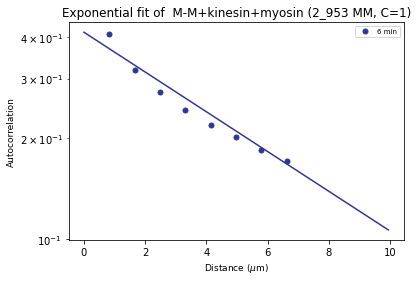

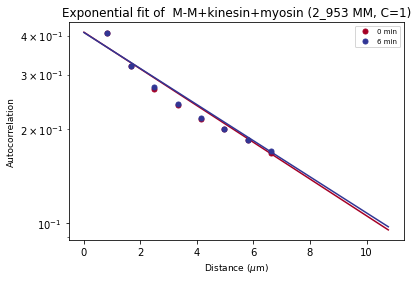

No handles with labels found to put in legend.


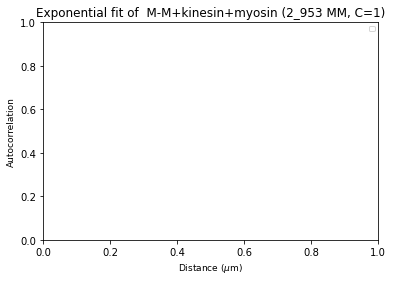

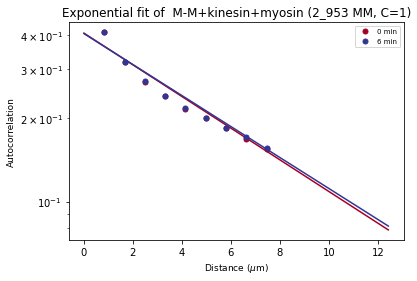

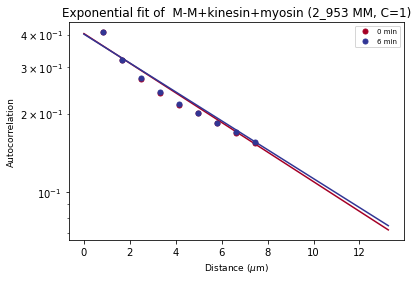

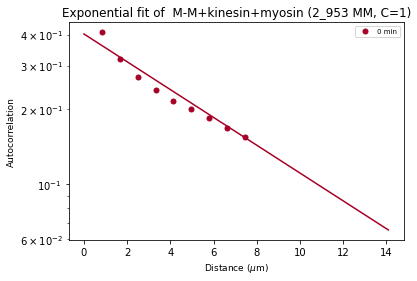

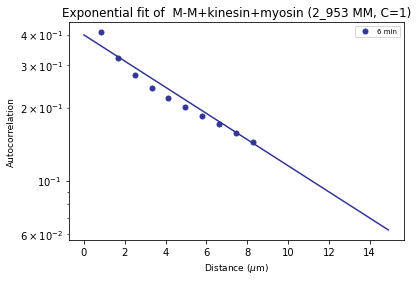

2
[array([0.4086822 , 0.31888459, 0.27058666, 0.23969463, 0.21639997,
       0.20026195, 0.18434199, 0.16815242, 0.15426124, 0.14098179]), array([0.40869266, 0.31939047, 0.27312649, 0.24141181, 0.21804157,
       0.20099449, 0.18455185, 0.17080168, 0.15639782, 0.14389803])]


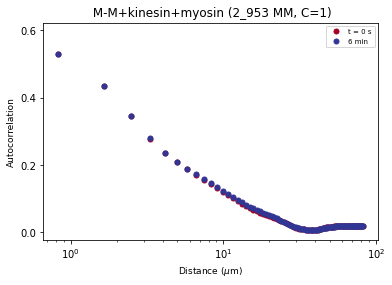

[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]


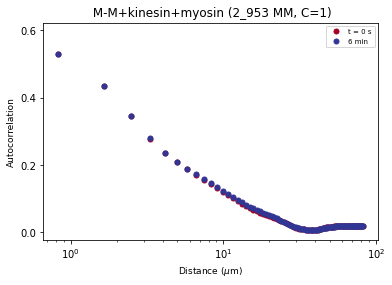

[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]
[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])]


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns               #version 0.9.0
import warnings                        #version 0.4.1
import pandas as pd                 #version 0.23.4
import os
import csv                          #version 1.0
import numpy as np                  #version 1.15.1
import pickle                       #revision: 72223
import time
import datetime
import math
from collections import defaultdict                        #version 3.4.3
import scipy
from scipy import optimize
import scipy.special as sc
import matplotlib.pyplot as plt
#powerlaw
'''
data_by_cond=np.genfromtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
            +finalFileLoc+"\\"+vid_date+"\\"+data_file+"_autocorrelation_data_"+str(chop)+length+".csv", delimiter=",")
dx=data_by_cond[:,0]
rows = data_by_cond[0]
cols = data_by_cond.shape[1]-1
fullset = np.zeros((data_by_cond.shape[0],data_by_cond.shape[1]-1))
for i in range(1,data_by_cond.shape[1]):
    temp = data_by_cond[:,i]
    fullset[:,i-1] = temp
'''

def powerlaw(t,A,C):
    return (A)*(t)**(C)

pow_param = np.zeros((corr_ravs.shape[0],2))
for i in range(corr_ravs.shape[0]):
    temp = scipy.optimize.curve_fit(powerlaw,xvalues[1:],corr_ravs[i][1:], absolute_sigma=True)
    pow_param[i,:] = temp[0]
    standerr = np.sqrt(np.diag(temp[1]))/np.sqrt(corr_ravs.shape[0])
#print(pow_param)

def exponential(t,A,k):
    return (A*np.exp(-k*t))

def exponent_par(xvalues,corr_ravs):
    exp_param = np.zeros((corr_ravs.shape[0],2))
    standerr = np.zeros((corr_ravs.shape[0],2))
    for i in range(corr_ravs.shape[0]):
        temp = scipy.optimize.curve_fit(exponential,xvalues[1:],corr_ravs[i][1:], absolute_sigma=True)
        exp_param[i,:] = temp[0]
        standerr[i,:] = np.sqrt(np.diag(temp[1]))/np.sqrt(corr_ravs.shape[0])
        #print(standerr,i)
        #print(corr_ravs.shape[0],corr_ravs.shape[1])
    return(exp_param,standerr)

def fit(param,x,y,function):
    for i in range(5,len(x)):
        res = y[i] - function(x[i],param[0],param[1])
        if res > 0:
            return i 
    return len(x)

'''
def FindMaxLength(lst): 
    maxList = max((i) for i in lst) 
    maxLength = max(len(i) for i in lst ) 
  
    return maxList, maxLength
'''
if ikey < 0: ikokay = -ikey
else: ikokay = ikey
if ikokay != 1: divis = ikokay-1
else: divis = ikokay
plt.figure()
for i in range(ikokay):
    plt.loglog(xvalues,corr_ravs[i],'.',ms=markerSize,c=cmap(i/(divis)),label=str(i*6)+' min')
    plt.plot(xvalues,powerlaw(xvalues,pow_param[i,0],pow_param[i,1]),c=cmap(i/(divis)))
plt.title("Power Law Fit of "+finalFileLoc+" ("+vid_ti+", "+c+")")
plt.xlabel("Distance ($\mu$m)",fontsize=9)
plt.ylabel("Autocorrelation",fontsize=9)
plt.legend(loc=0,fontsize=7)
plt.show()

'''
plt.figure()
for i in range(ikey):
    plt.semilogy(xvalues[:25],corr_ravs[i,:25],'.',ms=markerSize,c=cmap(i/(ikey-1)),label=str(i*6)+' min')
    plt.plot(xvalues[:25],exponential(xvalues[:25],exp_param[i,0],exp_param[i,1]),c=cmap(i/(ikey-1)))

plt.title("Exponential fit of "+finalFileLoc+" ("+vid_ti+", "+c+")")
plt.xlabel("Distance ($\mu$m)",fontsize=9)
plt.ylabel("Autocorrelation",fontsize=9)
plt.legend(loc=0,fontsize=7)
plt.show()
'''

fits = [0] * ikokay
print(fits)
for j in range (5,len(xvalues)):
    exp_param,standerr = exponent_par(xvalues[:j], corr_ravs[:,:j])
    plt.figure()
    for i in range(ikokay):
        temp_fit = fit(exp_param[i,:],xvalues[:j],corr_ravs[i,:j],exponential)
        if temp_fit > fits[i]:
            fits[i] = temp_fit
        elif findm == -1:
            plt.semilogy(xvalues[1:fits[i]+1],corr_ravs[i,1:fits[i]+1],'.',ms=markerSize,c=cmap(i/(divis)),label=un + " " + minut[i])
            plt.plot(xvalues[:j],exponential(xvalues[:j],exp_param[i,0],exp_param[i,1]),c=cmap(i/(divis)))
        elif find_hrs==0:
            plt.semilogy(xvalues[1:fits[i]+1],corr_ravs[i,1:fits[i]+1],'.',ms=markerSize,c=cmap(i/(divis)),label=str(i*6)+' min')
            plt.plot(xvalues[:j],exponential(xvalues[:j],exp_param[i,0],exp_param[i,1]),c=cmap(i/(divis)))
        else:
            plt.semilogy(xvalues[1:fits[i]+1],corr_ravs[i,1:fits[i]+1],'.',ms=markerSize,c=cmap(i/(divis)),label=minut[i]+" "+un)
            plt.plot(xvalues[:j],exponential(xvalues[:j],exp_param[i,0],exp_param[i,1]),c=cmap(i/(divis)))
        #plt.errorbar(xvalues[1:fits[i]+1],corr_ravs[i,1:fits[i]+1],yerr = standerr[i,1],fmt='o',c=cmap(i/(ikey-1)))
    plt.title("Exponential fit of "+finalFileLoc+" ("+vid_ti+", "+c+")")
    plt.xlabel("Distance ($\mu$m)",fontsize=9)
    plt.ylabel("Autocorrelation",fontsize=9)
    plt.legend(loc=0,fontsize=7)
    plt.show()
    if fits[np.argmax(fits)] + 8 < j:
        break
print(corr_ravs.shape[0])
corr_values = []
for i in range(corr_ravs.shape[0]):
    temp = corr_ravs[i,1:fits[i]+1]
    corr_values.insert(i, temp)
print(corr_values)
#mxlist, mxlen = FindMaxLength(corr_values)
x_dalues = []
for i in range(ikokay):
    xist = chip(len(corr_values[i]))
    print(xist)
    x_dalues.insert(i, xist)
print(x_dalues)

[[0.42188832 0.12169175]
 [0.42132736 0.11994176]] [[0.42188832 0.12169175 0.36811424]
 [0.42132736 0.11994176 0.36490773]] [[0.68954329 0.36811424]
 [0.68621262 0.36490773]]


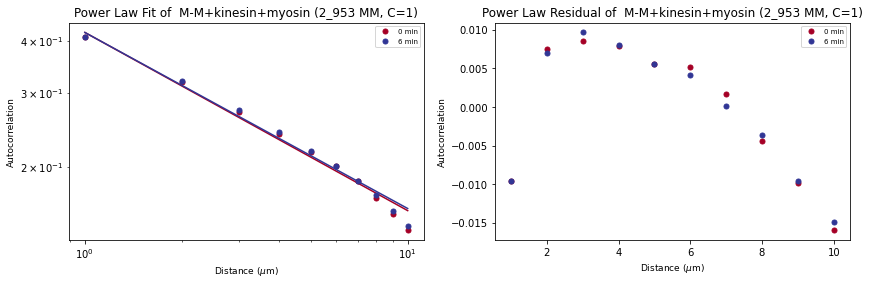

In [40]:
time = np.linspace(0,ikokay*6,ikokay)
def powerlaw(t,A,C):
    return (A)*(t)**(C)

pow_param = np.zeros((len(corr_values),2))
for i in range(len(corr_values)):
    temp = scipy.optimize.curve_fit(powerlaw,x_dalues[i],corr_values[i], absolute_sigma=True)
    pow_param[i,:] = temp[0]
#print(pow_param)

def exponential(t,A,k):
    return (A*np.exp(-k*t))

exp_param = np.zeros((len(corr_values),3))
exp_param1 = np.zeros((len(corr_values),2))
for i in range(len(corr_values)):
    temp = scipy.optimize.curve_fit(exponential,x_dalues[i],corr_values[i], absolute_sigma=True)
    standerr[i,:] = np.sqrt(np.diag(temp[1]))/np.sqrt(corr_ravs.shape[0])
    exp_param1[i,:] = temp[0]
for i in range(len(corr_values)):
    for j in range(exp_param.shape[1]-1):
        exp_param[i,j] = exp_param1[i,j]
    exp_param[i,2] = standerr[i,1]
print(exp_param1,exp_param,standerr)

if fps == .36:
    savetxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                +finalFileLoc+"\\"+vid_date+"\\Fits\\"+data_file+"_autocorrelation_pow_fit_chopped.csv",pow_param,delimiter=',')
    savetxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                +finalFileLoc+"\\"+vid_date+"\\Fits\\"+data_file+"_autocorrelation_exp_fit_chopped.csv",exp_param,delimiter=',')
else: 
    savetxt(saveto+"Fits\\"+data_file+"_autocorrelation_pow_fit_chopped.csv",pow_param,delimiter=',')
    savetxt(saveto+"Fits\\"+data_file+"_autocorrelation_exp_fit_chopped.csv",exp_param,delimiter=',')

fig, ax = plt.subplots(figsize=(14,4))
plt.subplot(1,2,1)
for i in range(ikokay):
    if findz != -1:
        plt.loglog(x_dalues[i],corr_values[i],'.',ms=markerSize,c=cmap(i/(ikokay-1)),label=un + " " + minut[i])
        plt.plot(x_dalues[i],powerlaw(x_dalues[i],pow_param[i,0],pow_param[i,1]),c=cmap(i/(ikokay-1)))
    elif find_hrs ==0:
        plt.loglog(x_dalues[i],corr_values[i],'.',ms=markerSize,c=cmap(i/(ikey-1)),label=str(i*6)+' min')
        plt.plot(x_dalues[i],powerlaw(x_dalues[i],pow_param[i,0],pow_param[i,1]),c=cmap(i/(ikey-1)))
    else: 
        plt.loglog(x_dalues[i],corr_values[i],'.',ms=markerSize,c=cmap(i/(ikey-1)),label=minut[i]+" "+un)
        plt.plot(x_dalues[i],powerlaw(x_dalues[i],pow_param[i,0],pow_param[i,1]),c=cmap(i/(ikey-1)))
plt.title("Power Law Fit of "+finalFileLoc+" ("+vid_ti+", "+c+")")
plt.xlabel("Distance ($\mu$m)",fontsize=9)
plt.ylabel("Autocorrelation",fontsize=9)
plt.legend(loc=0,fontsize=7)
#plt.locator_params(axis='y', nbins=5)
#plt.ylim(1e-3,1)
plt.subplot(1,2,2)
for i in range(ikokay):
    if findz != -1:
        plt.plot(x_dalues[i],corr_values[i] - powerlaw(x_dalues[i],pow_param[i,0],pow_param[i,1]),'.',ms=markerSize,
                     c=cmap(i/(ikokay-1)),label=un + " " + minut[i])
    elif find_hrs ==0:
        plt.plot(x_dalues[i],corr_values[i] - powerlaw(x_dalues[i],pow_param[i,0],pow_param[i,1]),'.',ms=markerSize,
                     c=cmap(i/(ikey-1)),label=str(i*6)+' min')
    else: plt.plot(x_dalues[i],corr_values[i] - powerlaw(x_dalues[i],pow_param[i,0],pow_param[i,1]),'.',ms=markerSize,
                     c=cmap(i/(ikey-1)),label=minut[i]+" "+un)
plt.title("Power Law Residual of "+finalFileLoc+" ("+vid_ti+", "+c+")")
plt.xlabel("Distance ($\mu$m)",fontsize=9)
plt.ylabel("Autocorrelation",fontsize=9)
plt.legend(loc=0,fontsize=7)
#plt.locator_params(axis='y', nbins=5)
plt.show()
if fps == .36:
    fig.savefig(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                +finalFileLoc+"\\"+vid_date+"\\Fits\\"+data_file+"_autocorrelation_pow_fit_chopped.png",dpi=600)
else: 
    fig.savefig(saveto+"Fits\\"+data_file+"_autocorrelation_pow_fit_chopped.png",dpi=600)

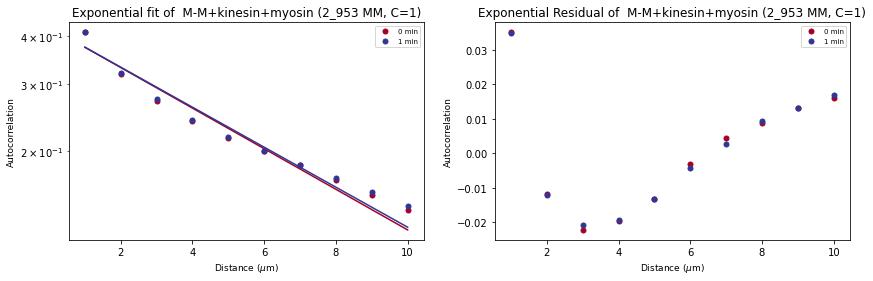

[[ 1.          0.40869266]
 [ 2.          0.31939047]
 [ 3.          0.27312649]
 [ 4.          0.24141181]
 [ 5.          0.21804157]
 [ 6.          0.20099449]
 [ 7.          0.18455185]
 [ 8.          0.17080168]
 [ 9.          0.15639782]
 [10.          0.14389803]]


In [41]:
fitter = []
fig, ax = plt.subplots(figsize=(14,4))
plt.subplot(1,2,1)
for i in range(ikokay):
    if find_hrs==0:
        if 6<=vid_len<=11:
            plt.semilogy(x_dalues[i],corr_values[i],'.',ms=markerSize,c=cmap(i/(ikey-1)),label=minut[i]+' min')
        else:
            plt.semilogy(x_dalues[i],corr_values[i],'.',ms=markerSize,c=cmap(i/(divis)),label=str(i*6)+' min')
    else: plt.semilogy(x_dalues[i],corr_values[i],'.',ms=markerSize,c=cmap(i/(divis)),label=minut[i]+" "+un)
    plt.plot(x_dalues[i],exponential(x_dalues[i],exp_param[i,0],exp_param[i,1]),c=cmap(i/(divis)))
plt.title("Exponential fit of "+finalFileLoc+" ("+vid_ti+", "+c+")")
plt.xlabel("Distance ($\mu$m)",fontsize=9)
plt.ylabel("Autocorrelation",fontsize=9)
plt.legend(loc=0,fontsize=7)
#plt.locator_params(axis='y', nbins=5)
#plt.ylim(1e-3,1)
plt.subplot(1,2,2)
for i in range(ikokay):
    if findz != -1:
        plt.plot(x_dalues[i],corr_values[i] - exponential(x_dalues[i],exp_param[i,0],exp_param[i,1]),'.',ms=markerSize,
                     c=cmap(i/(divis)),label=un+" "+minut[i])
    elif find_hrs==0 and findm==-1:
        plt.plot(x_dalues[i],corr_values[i] - exponential(x_dalues[i],exp_param[i,0],exp_param[i,1]),'.',ms=markerSize,
                     c=cmap(i/(ikey-1)),label=str(i*6)+' min')
    else:
        plt.plot(x_dalues[i],corr_values[i] - exponential(x_dalues[i],exp_param[i,0],exp_param[i,1]),'.',ms=markerSize,
                     c=cmap(i/(ikey-1)),label=minut[i]+" "+un)
plt.title("Exponential Residual of "+finalFileLoc+" ("+vid_ti+", "+c+")")
plt.xlabel("Distance ($\mu$m)",fontsize=9)
plt.ylabel("Autocorrelation",fontsize=9)
plt.legend(loc=0,fontsize=7)
#plt.locator_params(axis='y', nbins=5)
plt.show()
if fps == .36:
    fig.savefig(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                +finalFileLoc+"\\"+vid_date+"\\Fits\\"+data_file+"_autocorrelation_exp_fit_chopped.png",dpi=600)
else:
    fig.savefig(saveto+"Fits\\"+data_file+"_autocorrelation_exp_fit_chopped.png",dpi=600)
ari = np.zeros((len(x_dalues[-1]),2))
ari[:,0] = np.array(x_dalues[-1])
ari[:,1] = corr_values[-1]
#ari = np.array(ari)
print(ari)

In [42]:
if fps == .36:
    savetxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                               +finalFileLoc+"\\"+vid_date+"\\Fits\\"+data_file+"_autocorrelation_exp_fit_chopped_non"+
                          ".csv",ari ,delimiter=',')
else:
    savetxt(saveto+"\\Fits\\"+data_file+"_autocorrelation_exp_fit_chopped_non"+".csv",ari ,delimiter=',')

# Stoppp

In [30]:
def keyy(vid_len):
    if vid_len ==6:ikey = 5;
    elif 15<=vid_len <=18:ikey = 3;
    elif 20<=vid_len <=25:ikey = 4;
    elif 30<=vid_len <=36:ikey = 6;
    elif 42<=vid_len <=47:ikey = 8;
    return ikey

# Just for Figure Data, Can be ignored

found 14 files
 0 	 1_500_6min.nd2 - C=0_autocorrelation_data_every_6min_5frames.csv
 1 	 1_500_6min.nd2 - C=1_autocorrelation_data_every_6min_5frames.csv
 2 	 2_507_12min.nd2 - C=0_autocorrelation_data_every_6min_5frames.csv
 3 	 2_507_12min.nd2 - C=1_autocorrelation_data_every_6min_5frames.csv
 4 	 3_520_18min.nd2 - C=0_autocorrelation_data_every_6min_5frames.csv
 5 	 3_520_18min.nd2 - C=1_autocorrelation_data_every_6min_5frames.csv
 6 	 4_540_6min.nd2 - C=0_autocorrelation_data_every_6min_5frames.csv
 7 	 4_540_6min.nd2 - C=1_autocorrelation_data_every_6min_5frames.csv
 8 	 5_550_6min.nd2 - C=0_autocorrelation_data_every_6min_5frames.csv
 9 	 5_550_6min.nd2 - C=1_autocorrelation_data_every_6min_5frames.csv
 10 	 6_602_18min.nd2 - C=0_autocorrelation_data_every_6min_5frames.csv
 11 	 6_602_18min.nd2 - C=1_autocorrelation_data_every_6min_5frames.csv
 12 	 6_644_18min.nd2 - C=0_autocorrelation_data_every_6min_5frames.csv
 13 	 6_644_18min.nd2 - C=1_autocorrelation_data_every_6min_5fram

<ipython-input-43-ba1a52be1312>:72: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if texta4[-1] =="0":channela = "_microtubule_channel";


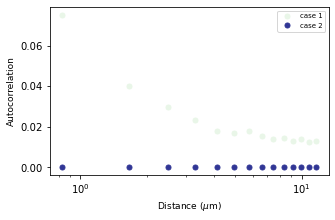

In [43]:
typee = "Kinesin\\"   # leave as an empty sting if Confocal videos isn't in a larger folder eg: Kinesin and add \\ at end if it is
exp = "211027_no XL + kinesin + myosin"          #folder name
foldy = ""                                      # leave as an empty sting if not needed
#data_file = "1_nokinesin_zstack.nd2 - C=1"   #tif file
zstackframes = 5; do_all=0   # change depending on what you want for autocorrelation, minimum 3; do_all: 0=no and 1 = yes
data_dir = directory+":\\Chris\\"+typee+"Confocal Videos\\"+exp+foldy+"\\raw tiffs\\"
saveto = directory+":\\Chris\\"+typee+"Confocal Videos\\"+exp+"\\SIA\\Graphs\\" 
giif = "*autocorrelation_data_every_6min_5frames*"
files = glob.glob(saveto+giif) 
files.sort()
print("found %i files" % len(files))
for i,f in enumerate(files): print (' %i \t %s' % (i, f.split('\\')[-1]))
    
data_files = []
for i in range(len(files)):
    full_data_file= files[i]
    data_files.append((full_data_file.split('\\')[-1])[:-4])
print(data_files)

texta1 = loadtxt(saveto+data_files[0]+".csv", delimiter=','); fex = 0
texta2 = loadtxt(saveto+data_files[1]+".csv", delimiter=','); fex = 1
#texta3 = loadtxt(saveto+data_files[11]+".csv", delimiter=','); fex = 2
#texta4 = loadtxt(saveto+data_files[12]+".csv", delimiter=','); fex = 3
#texta5 = loadtxt(saveto+data_files[13]+".csv", delimiter=','); fex = 4
#texta6 = loadtxt(saveto+data_files[14]+".csv", delimiter=','); fex = 5
#texta7 = loadtxt(saveto+data_files[15]+".csv", delimiter=','); fex = 6
#texta8 = loadtxt(saveto+data_files[16]+".csv", delimiter=','); fex = 7
#texta9 = loadtxt(saveto+data_files[17]+".csv", delimiter=','); fex = 8

print(texta1)

'''texta11 = np.zeros((texta1.shape[0],2));texta11[:,0] = texta1[:,0]
texta77 = np.zeros((texta7.shape[0],2));texta77[:,0] = texta7[:,0]
for i in range(texta1.shape[0]):
    texta11[i,1] = (texta1[i,1] + texta1[i,2]) / 2
    texta77[i,1] = (texta7[i,1] + texta7[i,2]) / 2'''

def filler(matrix,data,index):
    for i in range(data.shape[0]):
        matrix[i,index] = data[i,1]
    return matrix

text_dataa = np.empty((texta1.shape[0],fex+2))
for i in range(texta1.shape[0]):
    text_dataa[i,1] = texta1[i,1]
    text_dataa[i,0] = texta5[i,0]  # x coordinates
if fex > 1:
    text_dataa = filler(text_dataa,texta2,2)
    if fex > 2:
        text_dataa = filler(text_dataa,texta3,3)
        if fex > 3:
            text_dataa = filler(text_dataa,texta4,4)
            if fex > 4:
                text_dataa = filler(text_dataa,texta5,5)
                if fex > 5:
                    text_dataa = filler(text_dataa,texta6,6)
                    if fex > 6:
                        text_dataa = filler(text_dataa,texta7,7)
                        if fex > 7:
                            text_dataa = filler(text_dataa,texta8,8)
                            if fex > 8:
                                text_dataa = filler(text_dataa,texta9,9)

for i in range(1,text_dataa.shape[0]):
    for j in range(1,text_dataa.shape[1]):
        if text_dataa[i,j] < 10^-5 or text_dataa[i,j] > 2:
            text_dataa[i,j] = np.nan;
print(text_dataa.shape[1])


channela = "_actin_channel"
if texta4[-1] =="0":channela = "_microtubule_channel";
print(channela)
#print(alist)
yes = 0
yes = 1                                                      #comment out to ignore actin and microtubule same graph



savetxt(saveto+giif[1:-2]+"_Average_final_autocorrelation.csv",text_dataa,delimiter=',')
'''savetxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"
            +finalFileLoc+"\\"+vid_date+"\\Average_final_autocorrelation"+channela+length+".csv",avg_fin,delimiter=',')'''
    
fig, ax = plt.subplots(figsize=(5,5/1.618))
for i in range(1,text_dataa.shape[1]):
    plt.semilogx(text_dataa[1:15,0],text_dataa[1:15,i],'.',ms=markerSize,c=cmap(i/(text_dataa.shape[1]-1.25)),
                 label='case '+str(i))
plt.legend(loc=0,fontsize=7)
plt.xlabel("Distance ($\mu$m)",fontsize=9)
plt.ylabel("Autocorrelation",fontsize=9)
plt.show()

fig.savefig(saveto+giif[1:-2]+"_Average_final_autocorrelation.png",dpi=600)

In [48]:
"""
fityA1xMyf = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                           "50% actin 1x myosin\\20200910\\Fits\\"+text2+"_autocorrelation_exp_fit_chopped_non"+
                      ".csv", delimiter=',')
twenA1xMyf = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                           "25%actin\\20200909\\Fits\\"+text3+"_autocorrelation_exp_fit_chopped_non"+
                      ".csv", delimiter=',')
svenA1xMyf = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                           "75%actin\\20200805\\Fits\\"+text2+"_autocorrelation_exp_fit_chopped_non"+
                      ".csv", delimiter=',')
fityAp5xMyf = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                           "0.5x myosin\\20200908\\Fits\\"+text3+"_autocorrelation_exp_fit_chopped_non"+
                      ".csv", delimiter=',')
twenA2xMyf = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                           "25% actin 2x myosin\\20201215\\Fits\\"+text2+"_autocorrelation_exp_fit_chopped_non"+
                      ".csv", delimiter=',')
fityA2xMyf = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                           "2x myosin\\20200807\\Fits\\"+text2+"_autocorrelation_exp_fit_chopped_non"+
                      ".csv", delimiter=',')
svenAp5xMyf = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                           "75% actin 0.5x myosin\\20201218\\Fits\\"+text2+"_autocorrelation_exp_fit_chopped_non"+
                      ".csv", delimiter=',')
twenAp5xMyf = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                           "25% actin 0.5x myosin\\20210401\\Fits\\"+text4+"_autocorrelation_exp_fit_chopped_non"+
                      ".csv", delimiter=',')
svenA2xMyf = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                           "75% actin 2x myosin\\20210330\\Fits\\"+text4+"_autocorrelation_exp_fit_chopped_non"+
                      ".csv", delimiter=',')
"""

typee = "Kinesin\\"   # leave as an empty sting if Confocal videos isn't in a larger folder eg: Kinesin and add \\ at end if it is
exp = "211027_no XL + kinesin + myosin"          #folder name
foldy = ""                                      # leave as an empty sting if not needed
#data_file = "1_nokinesin_zstack.nd2 - C=1"   #tif file
zstackframes = 5; do_all=0   # change depending on what you want for autocorrelation, minimum 3; do_all: 0=no and 1 = yes
data_dir = directory+":\\Chris\\"+typee+"Confocal Videos\\"+exp+foldy+"\\raw tiffs\\"
saveto = directory+":\\Chris\\"+typee+"Confocal Videos\\"+exp+"\\SIA\\Fits\\" 
files = glob.glob(saveto+"*_autocorrelation_exp_fit_chopped.csv*") 
files.sort()
print("found %i files" % len(files))
for i,f in enumerate(files): print (' %i \t %s' % (i, f.split('\\')[-1]))

found 14 files
 0 	 1_500_6min.nd2 - C=0_autocorrelation_exp_fit_chopped.csv
 1 	 1_500_6min.nd2 - C=1_autocorrelation_exp_fit_chopped.csv
 2 	 2_507_12min.nd2 - C=0_autocorrelation_exp_fit_chopped.csv
 3 	 2_507_12min.nd2 - C=1_autocorrelation_exp_fit_chopped.csv
 4 	 3_520_18min.nd2 - C=0_autocorrelation_exp_fit_chopped.csv
 5 	 3_520_18min.nd2 - C=1_autocorrelation_exp_fit_chopped.csv
 6 	 4_540_6min.nd2 - C=0_autocorrelation_exp_fit_chopped.csv
 7 	 4_540_6min.nd2 - C=1_autocorrelation_exp_fit_chopped.csv
 8 	 5_550_6min.nd2 - C=0_autocorrelation_exp_fit_chopped.csv
 9 	 5_550_6min.nd2 - C=1_autocorrelation_exp_fit_chopped.csv
 10 	 6_602_18min.nd2 - C=0_autocorrelation_exp_fit_chopped.csv
 11 	 6_602_18min.nd2 - C=1_autocorrelation_exp_fit_chopped.csv
 12 	 6_644_18min.nd2 - C=0_autocorrelation_exp_fit_chopped.csv
 13 	 6_644_18min.nd2 - C=1_autocorrelation_exp_fit_chopped.csv


['1_Actin-0.25-Myosin-0.12 AT_9min.nd2 C=1_autocorrelation_exp_fit_chopped_non', '1_Actin-0.25-Myosin-0.24 AT_9min.nd2 C=1_autocorrelation_exp_fit_chopped_non', '1_Actin-0.25-Myosin-0.48 AT_9min.nd2 C=1_autocorrelation_exp_fit_chopped_non', '1_Actin-0.5-Myosin-0.12 AT_9min.nd2 C=1_autocorrelation_exp_fit_chopped_non', '1_Actin-0.5-Myosin-0.24  AT_9min.nd2 C=1_autocorrelation_exp_fit_chopped_non', '1_Actin-0.5-Myosin-0.48 AT_9min.nd2 C=1_autocorrelation_exp_fit_chopped_non', '1_Actin-0.75-Myosin-0.12 AT_9min.nd2 C=1_autocorrelation_exp_fit_chopped_non', '1_Actin-0.75-Myosin-0.24 AT_9min.nd2 C=1_autocorrelation_exp_fit_chopped_non', '1_Actin-0.75-Myosin-0.48 AT_9min.nd2 C=1_autocorrelation_exp_fit_chopped_non', '1_Actin-p2-0.25-p1-0.75-Myosin-rho-0.67 AT_9min.nd2 - C=1_autocorrelation_exp_fit_chopped_non', '1_Actin-p2-0.25-p1-0.75-Myosin-rho-0.83 AT_9min.nd2 - C=1_autocorrelation_exp_fit_chopped_non', '1_Actin-p2-0.25-p1-0.75-Myosin-rho-0.92 AT_9min.nd2 - C=1_autocorrelation_exp_fit_chop

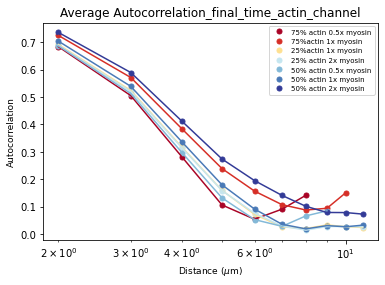

"\nfor i in range(8):\n    fityA1xMyf[i,1] = fityA1xMyf[-1,1]\n    svenA1xMyf[i,1] = svenA1xMyf[-1,1]\n    fityA2xMyf[i,1] = fityA2xMyf[-1,1]\nfor i in range(6):\n    twenA1xMyf[i,1] = twenA1xMyf[-1,1]\n    fityAp5xMyf[i,1] = fityAp5xMyf[-1,1]\narra = np.zeros(5)\narra[0] = fityA1xMyf[-1,1]\narra[1] = twenA1xMyf[-1,1]\narra[2] = svenA1xMyf[-1,1]\narra[3] = fityAp5xMyf[-1,1]\narra[4] = fityA2xMyf[-1,1]\nprint(arra)\nplt.plot(time2,1/fityA1xMyf[:,1],c=cmap(.01),label=str()+'Video 2')\nplt.plot(time3,1/twenA1xMyf[:,1],c=cmap(.15),label=str()+'Video 3')\nplt.plot(time2,1/svenA1xMyf[:,1],c=cmap(.3),label=str()+'Video 4')\nplt.plot(time3,1/fityAp5xMyf[:,1],c=cmap(.75),label=str()+'Video 5')\nplt.plot(time2,1/fityA2xMyf[:,1],c=cmap(.99),label=str()+'Video 6')\n"

In [1858]:
chan = 1
if chan == 1:
    channela = "_actin_channel"
else:
    channela = "_microtubule_channel"

tima = 0
tima = -1; simpla = ""     # tima = 0 for initial, tima = -1 for final

if tima == -1: simpla = "_final";
else: simpla = "_initial"

loader = directory+":\\Chris\\"+typee+"Confocal Videos\\"+exp+"\\SIA\\Fits\\" 

data_files = []
for i in range(len(files)):
    full_data_file= files[i]
    data_files.append((full_data_file.split('\\')[-1])[:-4])
print(data_files)
    

fityA1xMyf = loadtxt(loader+data_files[13]+".csv", delimiter=',')
twenA1xMyf = loadtxt(loader+data_files[10]+".csv", delimiter=',')
svenA1xMyf = loadtxt(loader+data_files[16]+".csv", delimiter=',')
fityAp5xMyf = loadtxt(loader+data_files[14]+".csv", delimiter=',')
twenA2xMyf = loadtxt(loader+data_files[9]+".csv", delimiter=',')
fityA2xMyf = loadtxt(loader+data_files[12]+".csv", delimiter=',')
svenAp5xMyf = loadtxt(loader+data_files[17]+".csv", delimiter=',')
twenAp5xMyf = loadtxt(loader+data_files[11]+".csv", delimiter=',')
svenA2xMyf = loadtxt(loader+data_files[15]+".csv", delimiter=',')


index2 = find_2nd(text2,"_")
findm2 = text2.find("m")
index3 = find_2nd(text3,"_")
findm3 = text3.find("m")
vid_len2 = float(text2[index2+1:findm2:1]); print(vid_len2);ikey2 = keyy(vid_len2);
vid_len3 = float(text3[index3+1:findm3:1]); ikey3 = keyy(vid_len3);
time2 = np.linspace(0,(ikey2-1)*6,ikey2)
time3 = np.linspace(0,(ikey3-1)*6,ikey3)

print(svenA1xMyf[:,1])

text_dataf = np.empty((14,8))
for i in range(svenA1xMyf.shape[0]):
    text_dataf[i,1] = svenA1xMyf[i,1]
for i in range(twenA1xMyf.shape[0]):
    text_dataf[i,2] = twenA1xMyf[i,1]
for i in range(fityA1xMyf.shape[0]):
    text_dataf[i,3] = fityA1xMyf[i,1]
for i in range(fityAp5xMyf.shape[0]):
    text_dataf[i,4] = fityAp5xMyf[i,1]
for i in range(fityA2xMyf.shape[0]):
    text_dataf[i,0] = fityA2xMyf[i,0]  # x coordinates
    text_dataf[i,5] = fityA2xMyf[i,1]
for i in range(svenA2xMyf.shape[0]):
    text_dataf[i,6] = svenA2xMyf[i,1]
for i in range(twenAp5xMyf.shape[0]):
    text_dataf[i,7] = twenAp5xMyf[i,1]
for i in range(1,text_dataf.shape[0]):
    for j in range(1,text_dataf.shape[1]):
        if text_dataf[i,j] == 0 or text_dataf[i,j] > 50:
            text_dataf[i,j] = np.nan;
print(text_dataf)

fig, ax = plt.subplots()
#plt.semilogy(time2,1/exp_param_2[:,1],c=cmap(.01),label=str()+'Video 2')
plt.semilogx(svenAp5xMyf[1:,0],svenAp5xMyf[1:,1],'.',ms=markerSize,c=cmap(.01),label=str()+'75% actin 0.5x myosin')
plt.plot(svenA1xMyf[1:,0],svenA1xMyf[1:,1],'.',ms=markerSize,c=cmap(.1),label=str()+'75%actin 1x myosin')
#plt.semilogx(svenA2xMyf[1:,0],svenA2xMyf[1:,1],'.',ms=markerSize,c=cmap(.2),label=str()+'75% actin 2x myosin')
#plt.plot(twenAp5xMyf[1:,0],twenAp5xMyf[1:,1],'.',ms=markerSize,c=cmap(.3),label=str()+'25% actin 0.5x myosin')
plt.plot(twenA1xMyf[1:,0],twenA1xMyf[1:,1],'.',ms=markerSize,c=cmap(.4),label=str()+'25%actin 1x myosin')
plt.plot(twenA2xMyf[1:,0],twenA2xMyf[1:,1],'.',ms=markerSize,c=cmap(.65),label=str()+'25% actin 2x myosin')
plt.plot(fityAp5xMyf[1:,0],fityAp5xMyf[1:,1],'.',ms=markerSize,c=cmap(.77),label=str()+'50% actin 0.5x myosin')
plt.plot(fityA1xMyf[1:,0],fityA1xMyf[1:,1],'.',ms=markerSize,c=cmap(.89),label=str()+'50% actin 1x myosin')
plt.plot(fityA2xMyf[1:,0],fityA2xMyf[1:,1],'.',ms=markerSize,c=cmap(.99),label=str()+'50% actin 2x myosin')

plt.plot(svenAp5xMyf[1:,0],svenAp5xMyf[1:,1],c=cmap(.01))
plt.plot(svenA1xMyf[1:,0],svenA1xMyf[1:,1],c=cmap(.1))
#plt.plot(svenA2xMyf[1:,0],svenA2xMyf[1:,1],c=cmap(.2))
#plt.plot(twenAp5xMyf[1:,0],twenAp5xMyf[1:,1],c=cmap(.3))
plt.plot(twenA1xMyf[1:,0],twenA1xMyf[1:,1],c=cmap(.4))
plt.plot(twenA2xMyf[1:,0],twenA2xMyf[1:,1],c=cmap(.65))
plt.plot(fityAp5xMyf[1:,0],fityAp5xMyf[1:,1],c=cmap(.77))
plt.plot(fityA1xMyf[1:,0],fityA1xMyf[1:,1],c=cmap(.89))
plt.plot(fityA2xMyf[1:,0],fityA2xMyf[1:,1],c=cmap(.99))
plt.xlabel("Distance ($\mu$m)",fontsize=9)
plt.ylabel("Autocorrelation",fontsize=9)
plt.title("Average Autocorrelation"+str(simpla)+"_time"+str(channela))
plt.legend(loc=0,fontsize=7)
#plt.ylim(0,20)
plt.show()

svenA1xMyf = np.array(svenA1xMyf)
twenA1xMyf = np.array(twenA1xMyf)
fityAp5xMyf = np.array(fityAp5xMyf)
fityA2xMyf = np.array(fityA2xMyf)
twenA2xMyf = np.array(twenA2xMyf)
svenAp5xMyf = np.array(svenAp5xMyf)
#twenAp5xMya = np.array(twenAp5xMya)
#svenA2xMya = np.array(svenA2xMya)

'''
for i in range(8):
    fityA1xMyf[i,1] = fityA1xMyf[-1,1]
    svenA1xMyf[i,1] = svenA1xMyf[-1,1]
    fityA2xMyf[i,1] = fityA2xMyf[-1,1]
for i in range(6):
    twenA1xMyf[i,1] = twenA1xMyf[-1,1]
    fityAp5xMyf[i,1] = fityAp5xMyf[-1,1]
arra = np.zeros(5)
arra[0] = fityA1xMyf[-1,1]
arra[1] = twenA1xMyf[-1,1]
arra[2] = svenA1xMyf[-1,1]
arra[3] = fityAp5xMyf[-1,1]
arra[4] = fityA2xMyf[-1,1]
print(arra)
plt.plot(time2,1/fityA1xMyf[:,1],c=cmap(.01),label=str()+'Video 2')
plt.plot(time3,1/twenA1xMyf[:,1],c=cmap(.15),label=str()+'Video 3')
plt.plot(time2,1/svenA1xMyf[:,1],c=cmap(.3),label=str()+'Video 4')
plt.plot(time3,1/fityAp5xMyf[:,1],c=cmap(.75),label=str()+'Video 5')
plt.plot(time2,1/fityA2xMyf[:,1],c=cmap(.99),label=str()+'Video 6')
'''
#savetxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
#            +"\\Fits\\Exponential_Param_all_exp_4_last_time_average_correlation_length_exp_fits_"
#        +"chopped.csv",text_dataf,delimiter=',')

found 14 files
 0 	 1_500_6min.nd2 - C=0_autocorrelation_exp_fit_chopped.csv
 1 	 1_500_6min.nd2 - C=1_autocorrelation_exp_fit_chopped.csv
 2 	 2_507_12min.nd2 - C=0_autocorrelation_exp_fit_chopped.csv
 3 	 2_507_12min.nd2 - C=1_autocorrelation_exp_fit_chopped.csv
 4 	 3_520_18min.nd2 - C=0_autocorrelation_exp_fit_chopped.csv
 5 	 3_520_18min.nd2 - C=1_autocorrelation_exp_fit_chopped.csv
 6 	 4_540_6min.nd2 - C=0_autocorrelation_exp_fit_chopped.csv
 7 	 4_540_6min.nd2 - C=1_autocorrelation_exp_fit_chopped.csv
 8 	 5_550_6min.nd2 - C=0_autocorrelation_exp_fit_chopped.csv
 9 	 5_550_6min.nd2 - C=1_autocorrelation_exp_fit_chopped.csv
 10 	 6_602_18min.nd2 - C=0_autocorrelation_exp_fit_chopped.csv
 11 	 6_602_18min.nd2 - C=1_autocorrelation_exp_fit_chopped.csv
 12 	 6_644_18min.nd2 - C=0_autocorrelation_exp_fit_chopped.csv
 13 	 6_644_18min.nd2 - C=1_autocorrelation_exp_fit_chopped.csv
['1_500_6min.nd2 - C=0_autocorrelation_exp_fit_chopped', '1_500_6min.nd2 - C=1_autocorrelation_exp_fit_ch

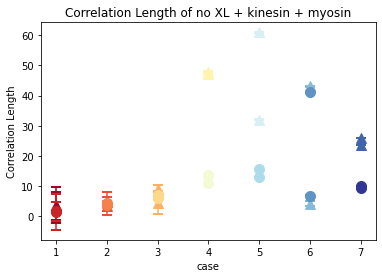

In [144]:
"""
211027_no XL + kinesin + myosin
211027_no XL + kinesin
211027_ M-M+kinesin+myosin
211027_ M-M + kinesin
211027_ A-A + kinesin + myosin
211027_ A-A + kinesin
"""

typee = "Kinesin\\"   # leave as an empty sting if Confocal videos isn't in a larger folder eg: Kinesin\\
exp = "211027_no XL + kinesin + myosin"          #folder name
foldy = ""                                      # leave as an empty sting if not needed
#data_file = "1_nokinesin_zstack.nd2 - C=1"   #tif file
zstackframes = 5; do_all=0   # change depending on what you want for autocorrelation, minimum 3; do_all: 0=no and 1 = yes
data_dir = directory+":\\Chris\\"+typee+"Confocal Videos\\"+exp+foldy+"\\raw tiffs\\"
saveto = directory+":\\Chris\\"+typee+"Confocal Videos\\"+exp+"\\SIA\\Fits\\" 
save = directory+":\\Chris\\"+typee+"Confocal Videos\\"+exp+"\\SIA\\Correlation\\" 
giif = "*_autocorrelation_exp_fit_chopped.csv*"
files = glob.glob(saveto+giif) 
files.sort()
print("found %i files" % len(files))
for i,f in enumerate(files): print (' %i \t %s' % (i, f.split('\\')[-1]))
    
data_files = []
for i in range(len(files)):
    full_data_file= files[i]
    data_files.append((full_data_file.split('\\')[-1])[:-4])
print(data_files)
gibbb = find_1st(exp,"_")
finalFileLoc = exp[gibbb+1: len(exp):1]

texta1 = loadtxt(saveto+data_files[0]+".csv", delimiter=','); fex = 0
texta2 = loadtxt(saveto+data_files[1]+".csv", delimiter=','); fex = 1
texta3 = loadtxt(saveto+data_files[2]+".csv", delimiter=','); fex = 2
texta4 = loadtxt(saveto+data_files[3]+".csv", delimiter=','); fex = 3
texta5 = loadtxt(saveto+data_files[4]+".csv", delimiter=','); fex = 4
texta6 = loadtxt(saveto+data_files[5]+".csv", delimiter=','); fex = 5
texta7 = loadtxt(saveto+data_files[6]+".csv", delimiter=','); fex = 6
texta8 = loadtxt(saveto+data_files[7]+".csv", delimiter=','); fex = 7
texta9 = loadtxt(saveto+data_files[8]+".csv", delimiter=','); fex = 8
texta10 = loadtxt(saveto+data_files[9]+".csv", delimiter=','); fex = 9
texta11 = loadtxt(saveto+data_files[10]+".csv", delimiter=','); fex = 10
texta12 = loadtxt(saveto+data_files[11]+".csv", delimiter=','); fex = 11
texta13 = loadtxt(saveto+data_files[12]+".csv", delimiter=','); fex = 12
texta14 = loadtxt(saveto+data_files[13]+".csv", delimiter=','); fex = 13
#texta15 = loadtxt(saveto+data_files[14]+".csv", delimiter=','); fex = 14
#texta16 = loadtxt(saveto+data_files[15]+".csv", delimiter=','); fex = 15

#print(texta1)

'''texta11 = np.zeros((texta1.shape[0],2));texta11[:,0] = texta1[:,0]
texta77 = np.zeros((texta7.shape[0],2));texta77[:,0] = texta7[:,0]
for i in range(texta1.shape[0]):
    texta11[i,1] = (texta1[i,1] + texta1[i,2]) / 2
    texta77[i,1] = (texta7[i,1] + texta7[i,2]) / 2'''

def filleria(matrix,info,index):
    for i in range(1,info.shape[1]):
        matrix[index,i] = info[0,i]
        matrix[index,i+2] = info[1,i]
    return matrix

x = []
if fex%2 != 0:
    for i in range(1,fex-int(fex/2)+1):
        x.append(i);x.append(i);
else:
    for i in range(1,fex/2+1):
        x.append(i);x.append(i);
    
#print(fex,x)
#print(texta8)

text_dataa = np.zeros((fex+1,5))
for i in range(1,texta1.shape[1]):
    text_dataa[0,i] = texta1[0,i]
    text_dataa[0,i+2] = texta1[1,i]
print(text_dataa)
if fex > 0:
    text_dataa = filleria(text_dataa,texta2,1)
    if fex > 1:
        text_dataa = filleria(text_dataa,texta3,2)
        if fex > 2:
            text_dataa = filleria(text_dataa,texta4,3)
            if fex > 3:
                text_dataa = filleria(text_dataa,texta5,4)
                if fex > 4:
                    text_dataa = filleria(text_dataa,texta6,5)
                    if fex > 5:
                        text_dataa = filleria(text_dataa,texta7,6)
                        if fex > 6:
                            text_dataa = filleria(text_dataa,texta8,7)
                            if fex > 7:
                                text_dataa = filleria(text_dataa,texta9,8)
                                if fex > 8:
                                    text_dataa = filleria(text_dataa,texta10,9)
                                    if fex > 9:
                                        text_dataa = filleria(text_dataa,texta11,10)
                                        if fex > 10:
                                            text_dataa = filleria(text_dataa,texta12,11)
                                            if fex > 11:
                                                text_dataa = filleria(text_dataa,texta13,12)
                                                if fex > 12:
                                                    text_dataa = filleria(text_dataa,texta14,13)
                                                    if fex > 13:
                                                        text_dataa = filleria(text_dataa,texta15,14)
                                                        if fex > 14:
                                                            text_dataa = filleria(text_dataa,texta16,15)

text_dataa[:,0] = x[0::1]
'''for i in range(1,text_dataf.shape[0]):
    for j in range(1,text_dataa.shape[1]):
        if text_dataa[i,j] == 0 or text_dataa[i,j] > 50:
            text_dataa[i,j] = np.nan;'''
#print(text_dataa)

fig, ax = plt.subplots(figsize=(6,4))
color = np.linspace(0,1,fex+1)
symbol = ['^','o']

print(text_dataa[:,0])

for i in range(text_dataa.shape[0]):
    plt.plot(text_dataa[i,0],1/text_dataa[i,1],symbol[i%2],ms=markerSize,c=cmap(color[i]),label='case '+str(i+1))
    plt.errorbar(text_dataa[i,0],1/text_dataa[i,1],yerr=text_dataa[i,2],capsize=5,capthick=2,c=cmap(color[i]))
    plt.plot(text_dataa[i,0],1/text_dataa[i,1],c=cmap(color[i]))
    
    plt.plot(text_dataa[i,0],1/text_dataa[i,3],symbol[i%2],ms=markerSize,c=cmap(color[i]),label='case '+str(i+1))
    plt.errorbar(text_dataa[i,0],1/text_dataa[i,3],yerr=text_dataa[i,4],capsize=5,capthick=2,c=cmap(color[i]))
    plt.plot(text_dataa[i,0],1/text_dataa[i,3],c=cmap(color[i]))


plt.ylabel("Correlation Length")
plt.xlabel("case")
plt.title("Correlation Length of "+finalFileLoc)
#plt.legend(loc=0,fontsize=7)
plt.show()

text_dataa[:,1] = 1/text_dataa[:,1]
text_dataa[:,3] = 1/text_dataa[:,3]

fig.savefig(save+giif[1:-5]+"_correlation_length.png",dpi=600)
savetxt(save+giif[1:-5]+"_correlation_length.csv",text_dataa,delimiter=',')

In [1287]:
'''
resid = np.zeros((corr_values.shape[0],corr_values.shape[1]))
for i in range(ikey):
    resid[i] = corr_values[i] - exponential(x_dalues,exp_param[i,0],exp_param[i,1])
fig, ax = plt.subplots(figsize=(12,4))
plt.subplot(1,2,1)
indie = 0
#print(corr_values)
for i in range(ikey):
    for j in range(corr_values.shape[1]):
        if resid[i,j] * resid[i,+1] < 0:
            indie = indie +1
            if indie > 1:
                indie = j
                j = corr_values.shape[1]
    plt.semilogy(x_dalues[:indie],corr_values[i,:indie],'.',ms=markerSize,c=cmap(i/(ikey-1)),label=str(i*6)+' min')
    plt.plot(x_dalues[:indie],exponential(x_dalues[:indie],exp_param[i,0],exp_param[i,1]),c=cmap(i/(ikey-1)))
plt.title("Exponential fit of "+finalFileLoc+" ("+vid_ti+", "+c+")")
plt.xlabel("Distance ($\mu$m)",fontsize=9)
plt.ylabel("Autocorrelation",fontsize=9)
plt.legend(loc=0,fontsize=7)
#plt.locator_params(axis='y', nbins=5)
#plt.ylim(1e-3,1)
indie =0
plt.subplot(1,2,2)
for i in range(ikey):
    for j in range(corr_values.shape[1]):
        if resid[i,j] * resid[i,+1] < 0:
            indie = indie +1
            if indie > 1:
                indie = j
                j = corr_values.shape[1]
    plt.plot(x_dalues[:indie],corr_values[i,:indie] - exponential(x_dalues[:indie],exp_param[i,0],exp_param[i,1]),'.',ms=markerSize,
                 c=cmap(i/(ikey-1)),label=str(i*6)+' min')
plt.title("Exponential Residual of "+finalFileLoc+" ("+vid_ti+", "+c+")")
plt.xlabel("Distance ($\mu$m)",fontsize=9)
plt.ylabel("Autocorrelation",fontsize=9)
plt.legend(loc=0,fontsize=7)
#plt.locator_params(axis='y', nbins=5)
plt.show()
fig.savefig(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
            +finalFileLoc+"\\"+vid_date+"\\Fits\\"+data_file+"_autocorrelation_exp_fit_"+str(chop)+length+".png",dpi=600)
'''

'\nresid = np.zeros((corr_values.shape[0],corr_values.shape[1]))\nfor i in range(ikey):\n    resid[i] = corr_values[i] - exponential(x_dalues,exp_param[i,0],exp_param[i,1])\nfig, ax = plt.subplots(figsize=(12,4))\nplt.subplot(1,2,1)\nindie = 0\n#print(corr_values)\nfor i in range(ikey):\n    for j in range(corr_values.shape[1]):\n        if resid[i,j] * resid[i,+1] < 0:\n            indie = indie +1\n            if indie > 1:\n                indie = j\n                j = corr_values.shape[1]\n    plt.semilogy(x_dalues[:indie],corr_values[i,:indie],\'.\',ms=markerSize,c=cmap(i/(ikey-1)),label=str(i*6)+\' min\')\n    plt.plot(x_dalues[:indie],exponential(x_dalues[:indie],exp_param[i,0],exp_param[i,1]),c=cmap(i/(ikey-1)))\nplt.title("Exponential fit of "+finalFileLoc+" ("+vid_ti+", "+c+")")\nplt.xlabel("Distance ($\\mu$m)",fontsize=9)\nplt.ylabel("Autocorrelation",fontsize=9)\nplt.legend(loc=0,fontsize=7)\n#plt.locator_params(axis=\'y\', nbins=5)\n#plt.ylim(1e-3,1)\nindie =0\nplt.subplo

# Average Autocorrelation

In [727]:
exp = "20210330_5.8 AMT 75% actin 2x myosin"          #folder name
data_dir = directory+":\\Gregor L\\Confocal Videos\\"+exp+"\\raw tiffs\\"
data_file = "1_+488_45min.nd2 - C=0"          #tif file

def find_2nd(string, substring):
    return string.find(substring, string.find(substring) + 1)

finame = find_2nd(exp," ")
finalFileLoc = exp[finame+1: len(exp):1]
vid_len = 6

index = find_2nd(data_file,"_")
findm = data_file.find("m")
find_ = exp.find("_")
vid_len = float(data_file[index+1:findm:1])          #Comment out if you want just first 6 min
vid_date = exp[0:find_:1]                     #Remeber to make a folder under each type of exp for date
vid_ti = data_file[0:index:1]
c = data_file[len(data_file)-3:len(data_file):1]

a,b,c,d,e=0,0,0,0,0
alist=[]
texta2 = "1_+488_45min.nd2 - C=1"; texta2o = texta2[:-1];alist.append(2);
texta3 = "2_+488_45min.nd2 - C=1"; texta3o = texta3[:-1];alist.append(3);
#texta4 = "4_+488_45min.nd2 - C=0"; texta4o = texta4[:-1];alist.append(4);
#texta5 = "5_+488_45min.nd2 - C=0"; texta5o = texta5[:-1];alist.append(5);
#texta6 = "6_+488_20min.nd2 - C=0"; texta6o = texta6[:-1];alist.append(6);

channela = "_actin_channel"
if texta4[-1] =="0":channela = "_microtubule_channel";
print(channela)
print(alist)
yes = 0
yes = 1                                                      #comment out to ignore actin and microtubule same graph

if 2 in alist:
    vid_auto_2 = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"
                           +finalFileLoc+"\\"+vid_date+"\\"+texta2+"_autocorrelation_data"+length+
                      '.csv', delimiter=',')
else:vid_auto_2 = np.zeros((100,2))
if 3 in alist:
    vid_auto_3 = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"
                           +finalFileLoc+"\\"+vid_date+"\\"+texta3+"_autocorrelation_data_every_6min"+
                      ".csv", delimiter=',')
else:vid_auto_3 = np.zeros((100,2))
if 4 in alist:
    vid_auto_4 = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"
                           +finalFileLoc+"\\"+vid_date+"\\"+texta4+"_autocorrelation_data_every_6min"+
                      ".csv", delimiter=',')
else:vid_auto_4 = np.zeros((100,2))
if 5 in alist:
    vid_auto_5 = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"
                           +finalFileLoc+"\\"+vid_date+"\\"+texta5+"_autocorrelation_data_every_6min"+
                      ".csv", delimiter=',')
else:vid_auto_5 = np.zeros((100,2))
if 6 in alist:
    vid_auto_6 = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"
                           +finalFileLoc+"\\"+vid_date+"\\"+texta6+"_autocorrelation_data_every_6min"+
                      ".csv", delimiter=',')
else:vid_auto_6 = np.zeros((100,2))

avg_init = np.zeros((100,2))
avg_fin = np.zeros((100,2))

avg_init[:,0] = vid_auto_2[:,0]
avg_fin[:,0] = vid_auto_2[:,0]
i = len(alist)
for j in range(avg_init.shape[0]):
    avg_init[j,1] = (vid_auto_2[j,1] + vid_auto_3[j,1] + vid_auto_4[j,1] + vid_auto_5[j,1] + vid_auto_6[j,1]) / i
    avg_fin[j,1] = (vid_auto_2[j,-1] + vid_auto_3[j,-1] + vid_auto_4[j,-1] + vid_auto_5[j,-1] + vid_auto_6[j,-1]) / i

savetxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"
            +finalFileLoc+"\\"+vid_date+"\\Average_initial_autocorrelation"+channela+length+".csv",avg_init,delimiter=',')
savetxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"
            +finalFileLoc+"\\"+vid_date+"\\Average_final_autocorrelation"+channela+length+".csv",avg_fin,delimiter=',')
    
plt.figure()
plt.semilogx(avg_init[1:,0],avg_init[1:,1])
plt.semilogx(avg_fin[1:,0],avg_fin[1:,1],c='k')
plt.show()

NameError: name 'texta4' is not defined

# All Average Autocorrelations 

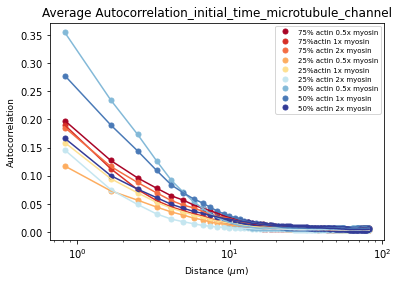

In [350]:
chan = 1
if chan == 1:
    channela = "_actin_channel"
else:
    channela = "_microtubule_channel"

tima = 0
tima = -1; simpla = ""     # tima = 0 for initial, tima = -1 for final

if tima == -1: simpla = "_final";
else: simpla = "_initial"

fityA1xMya = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"+
                           "50% actin 1x myosin\\20200910\\Average"+simpla+"_autocorrelation"+channela+length+
                      ".csv", delimiter=',')
twenA1xMya = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"+
                           "25%actin\\20200909\\Average"+simpla+"_autocorrelation"+channela+length+
                      ".csv", delimiter=',')
svenA1xMya = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"+
                           "75%actin\\20200805\\Average"+simpla+"_autocorrelation"+channela+length+
                      ".csv", delimiter=',')
fityAp5xMya = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"+
                           "0.5x myosin\\20200908\\Average"+simpla+"_autocorrelation"+channela+length+
                      ".csv", delimiter=',')
fityA2xMya = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"+
                           "2x myosin\\20200807\\Average"+simpla+"_autocorrelation"+channela+length+
                      ".csv", delimiter=',')
twenA2xMya = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"+
                           "25% actin 2x myosin\\20201215\\Average"+simpla+"_autocorrelation"+channela+length+
                      ".csv", delimiter=',')
svenAp5xMya = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"+
                           "75% actin 0.5x myosin\\20201218\\Average"+simpla+"_autocorrelation"+channela+length+
                      ".csv", delimiter=',')
twenAp5xMya = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"+
                           "25% actin 0.5x myosin\\20210401\\Average"+simpla+"_autocorrelation"+channela+length+
                      ".csv", delimiter=',')
svenA2xMya = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"+
                           "75% actin 2x myosin\\20210330\\Average"+simpla+"_autocorrelation"+channela+length+
                      ".csv", delimiter=',')

fig, ax = plt.subplots()
#plt.semilogy(time2,1/exp_param_2[:,1],c=cmap(.01),label=str()+'Video 2')
plt.semilogx(svenAp5xMya[1:,0],svenAp5xMya[1:,1],'.',ms=markerSize,c=cmap(.01),label=str()+'75% actin 0.5x myosin')
plt.plot(svenA1xMya[1:,0],svenA1xMya[1:,1],'.',ms=markerSize,c=cmap(.1),label=str()+'75%actin 1x myosin')
plt.semilogx(svenA2xMya[1:,0],svenA2xMya[1:,1],'.',ms=markerSize,c=cmap(.2),label=str()+'75% actin 2x myosin')
plt.plot(twenAp5xMya[1:,0],twenAp5xMya[1:,1],'.',ms=markerSize,c=cmap(.3),label=str()+'25% actin 0.5x myosin')
plt.plot(twenA1xMya[1:,0],twenA1xMya[1:,1],'.',ms=markerSize,c=cmap(.4),label=str()+'25%actin 1x myosin')
plt.plot(twenA2xMya[1:,0],twenA2xMya[1:,1],'.',ms=markerSize,c=cmap(.65),label=str()+'25% actin 2x myosin')
plt.plot(fityAp5xMya[1:,0],fityAp5xMya[1:,1],'.',ms=markerSize,c=cmap(.77),label=str()+'50% actin 0.5x myosin')
plt.plot(fityA1xMya[1:,0],fityA1xMya[1:,1],'.',ms=markerSize,c=cmap(.89),label=str()+'50% actin 1x myosin')
plt.plot(fityA2xMya[1:,0],fityA2xMya[1:,1],'.',ms=markerSize,c=cmap(.99),label=str()+'50% actin 2x myosin')

plt.plot(svenAp5xMya[1:,0],svenAp5xMya[1:,1],c=cmap(.01))
plt.plot(svenA1xMya[1:,0],svenA1xMya[1:,1],c=cmap(.1))
plt.plot(svenA2xMya[1:,0],svenA2xMya[1:,1],c=cmap(.2))
plt.plot(twenAp5xMya[1:,0],twenAp5xMya[1:,1],c=cmap(.3))
plt.plot(twenA1xMya[1:,0],twenA1xMya[1:,1],c=cmap(.4))
plt.plot(twenA2xMya[1:,0],twenA2xMya[1:,1],c=cmap(.65))
plt.plot(fityAp5xMya[1:,0],fityAp5xMya[1:,1],c=cmap(.77))
plt.plot(fityA1xMya[1:,0],fityA1xMya[1:,1],c=cmap(.89))
plt.plot(fityA2xMya[1:,0],fityA2xMya[1:,1],c=cmap(.99))
plt.xlabel("Distance ($\mu$m)",fontsize=9)
plt.ylabel("Autocorrelation",fontsize=9)
plt.title("Average Autocorrelation"+str(simpla)+"_time"+str(channela))
plt.legend(loc=0,fontsize=7)
#plt.ylim(0,20)
plt.show()

svenA1xMya = np.array(svenA1xMya)
twenA1xMya = np.array(twenA1xMya)
fityAp5xMya = np.array(fityAp5xMya)
fityA2xMya = np.array(fityA2xMya)
twenA2xMya = np.array(twenA2xMya)
svenAp5xMya = np.array(svenAp5xMya)
twenAp5xMya = np.array(twenAp5xMya)
svenA2xMya = np.array(svenA2xMya)

In [351]:
text_dat = np.empty((99,10))
for i in range(1,100):
    text_dat[i-1,1] = svenAp5xMya[i,1]
for i in range(1,100):
    text_dat[i-1,0] = svenA1xMya[i,0]
    text_dat[i-1,2] = svenA1xMya[i,1]
for i in range(1,100):
    text_dat[i-1,3] = svenA2xMya[i,1]
for i in range(1,100):
    text_dat[i-1,4] = twenAp5xMya[i,1]
for i in range(1,100):
    text_dat[i-1,5] = twenA1xMya[i,1]
for i in range(1,100):
    text_dat[i-1,6] = twenA2xMya[i,1]
for i in range(1,100):
    text_dat[i-1,7] = fityAp5xMya[i,1]
for i in range(1,100):
    text_dat[i-1,8] = fityA1xMya[i,1]
for i in range(1,100):
    text_dat[i-1,9] = fityA2xMya[i,1]
print(text_dat[:,0])
savetxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"
            +"\\Averages\\Average_Autocorrelation"+str(simpla)+"_time"+str(channela)
        +".csv",text_dat,delimiter=',')

[ 0.828  1.656  2.484  3.312  4.14   4.968  5.796  6.624  7.452  8.28
  9.108  9.936 10.764 11.592 12.42  13.248 14.076 14.904 15.732 16.56
 17.388 18.216 19.044 19.872 20.7   21.528 22.356 23.184 24.012 24.84
 25.668 26.496 27.324 28.152 28.98  29.808 30.636 31.464 32.292 33.12
 33.948 34.776 35.604 36.432 37.26  38.088 38.916 39.744 40.572 41.4
 42.228 43.056 43.884 44.712 45.54  46.368 47.196 48.024 48.852 49.68
 50.508 51.336 52.164 52.992 53.82  54.648 55.476 56.304 57.132 57.96
 58.788 59.616 60.444 61.272 62.1   62.928 63.756 64.584 65.412 66.24
 67.068 67.896 68.724 69.552 70.38  71.208 72.036 72.864 73.692 74.52
 75.348 76.176 77.004 77.832 78.66  79.488 80.316 81.144 81.972]


### Fitting Averages  ---  This section doesnt work, just put the autocorrelation averages in Origin and Fit

In [423]:
'''def exponent_para(xvalues,corr_ravs):
    print(corr_ravs.shape[0])
    exp_param = np.zeros((corr_ravs.shape[1],2))
    standerr = np.zeros((corr_ravs.shape[1],2))
    for i in range(corr_ravs.shape[1]):
        print(corr_ravs[:,i])
        temp = scipy.optimize.curve_fit(exponential,xvalues[:],corr_ravs[:][i], absolute_sigma=True)
        exp_param[i,:] = temp[0]
        standerr[i,:] = np.sqrt(np.diag(temp[1]))/np.sqrt(corr_ravs.shape[0])
        #print(standerr,i)
        #print(corr_ravs.shape[0],corr_ravs.shape[1])
    return(exp_param,standerr)

def fita(param,x,y,function):
    for i in range(5,len(x)):
        res = y[i] - function(x[i],param[0],param[1])
        if res > 0:
            return i 
    return len(x)

fits = [0] * 9  # 9 is the number of experiments 
for j in range (5,text_dat.shape[0]):
    print(text_dat[:j,0],text_dat[:j,1:])
    exp_param,standerr = exponent_para(text_dat[:j,0], text_dat[:j,1:])
    plt.figure()
    for i in range(1,text_dat.shape[1]):
        temp_fit = fita(exp_param[i,:],text_dat[:j,0],text_dat[:j,i],exponential)
        if temp_fit > fits[i]:
            fits[i] = temp_fit
        plt.semilogy(xvalues[1:fits[i]+1],corr_ravs[i,1:fits[i]+1],'.',ms=markerSize,c=cmap(i/(ikey-1)),label=str(i*6)+' min')
        plt.plot(xvalues[:j],exponential(xvalues[:j],exp_param[i,0],exp_param[i,1]),c=cmap(i/(ikey-1)))
        #plt.errorbar(xvalues[1:fits[i]+1],corr_ravs[i,1:fits[i]+1],yerr = standerr[i,1],fmt='o',c=cmap(i/(ikey-1)))
    plt.title("Exponential fit of "+finalFileLoc+" ("+vid_ti+", "+c+")")
    plt.xlabel("Distance ($\mu$m)",fontsize=9)
    plt.ylabel("Autocorrelation",fontsize=9)
    plt.legend(loc=0,fontsize=7)
    plt.show()
    if fits[np.argmax(fits)] + 8 < j:
        break
        
    print(text_dat[:j,0],text_dat[:j,1:])
    exp_param = []
    standerr = []
    for i in range(1,text_dat.shape[1]):
        temp1, temp2 = exponent_para(text_dat[:j,0], text_dat[:j,i])
        exp_param.append(temp1)
        standerr.append(temp2)
    plt.figure()
    for i in range(1,text_dat.shape[1]):
        temp_fit = fita(exp_param[i],text_dat[:j,0],text_dat[:j,i],exponential)
        if temp_fit > fits[i]:
            fits[i] = temp_fit
        plt.semilogy(xvalues[1:fits[i]+1],corr_ravs[i,1:fits[i]+1],'.',ms=markerSize,c=cmap(i/(ikey-1)),label=str(i*6)+' min')
        plt.plot(xvalues[:j],exponential(xvalues[:j],exp_param[i][0,i],exp_param[i][1,i]),c=cmap(i/(ikey-1)))
        #plt.errorbar(xvalues[1:fits[i]+1],corr_ravs[i,1:fits[i]+1],yerr = standerr[i,1],fmt='o',c=cmap(i/(ikey-1)))
    plt.title("Exponential fit of "+finalFileLoc+" ("+vid_ti+", "+c+")")
    plt.xlabel("Distance ($\mu$m)",fontsize=9)
    plt.ylabel("Autocorrelation",fontsize=9)
    plt.legend(loc=0,fontsize=7)
    plt.show()
    if fits[np.argmax(fits)] + 8 < j:
        break
        
ikey = 9
corr_text = []
for i in range(text_dat.shape[0]):
    temp = text_dat[i,1:fits[i]+1]
    corr_text.insert(i, temp)
print(text)
#mxlist, mxlen = FindMaxLength(corr_values)
x_dalues = []
for i in range(ikey):
    xist = chip(len(corr_text[i]))
    #print(xist)
    x_dalues.insert(i, xist)
print(x_dalues)        
        
exp_param = np.zeros((len(corr_text),3))
exp_param1 = np.zeros((len(corr_text),2))
for i in range(len(corr_text)):
    temp = scipy.optimize.curve_fit(exponential,x_dalues[i],corr_text[i], absolute_sigma=True)
    standerr[i,:] = np.sqrt(np.diag(temp[1]))/np.sqrt(text_dat.shape[0])
    exp_param1[i,:] = temp[0]
for i in range(len(corr_text)):
    for j in range(exp_param.shape[1]-1):
        exp_param[i,j] = exp_param1[i,j]
    exp_param[i,2] = standerr[i,1]
print(exp_param1,exp_param,standerr)'''

'def exponent_para(xvalues,corr_ravs):\n    print(corr_ravs.shape[0])\n    exp_param = np.zeros((corr_ravs.shape[1],2))\n    standerr = np.zeros((corr_ravs.shape[1],2))\n    for i in range(corr_ravs.shape[1]):\n        print(corr_ravs[:,i])\n        temp = scipy.optimize.curve_fit(exponential,xvalues[:],corr_ravs[:][i], absolute_sigma=True)\n        exp_param[i,:] = temp[0]\n        standerr[i,:] = np.sqrt(np.diag(temp[1]))/np.sqrt(corr_ravs.shape[0])\n        #print(standerr,i)\n        #print(corr_ravs.shape[0],corr_ravs.shape[1])\n    return(exp_param,standerr)\n\ndef fita(param,x,y,function):\n    for i in range(5,len(x)):\n        res = y[i] - function(x[i],param[0],param[1])\n        if res > 0:\n            return i \n    return len(x)\n\nfits = [0] * 9  # 9 is the number of experiments \nfor j in range (5,text_dat.shape[0]):\n    print(text_dat[:j,0],text_dat[:j,1:])\n    exp_param,standerr = exponent_para(text_dat[:j,0], text_dat[:j,1:])\n    plt.figure()\n    for i in range(1

# Fitting Param

_actin_channel
45.0
The length of each video are: 45.0, 45.0, 45.0, 45.0, and 45.0 minutes respectively


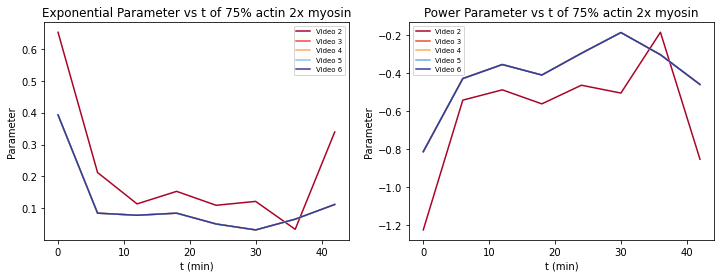

In [422]:
exp = "20210330_5.8 AMT 75% actin 2x myosin"          #folder name
data_dir = directory+":\\Gloria\\Confocal Videos\\"+exp+"\\raw tiffs\\"
data_file = "1_+488_45min.nd2 - C=0"          #tif file

def find_2nd(string, substring):
    return string.find(substring, string.find(substring) + 1)

finame = find_2nd(exp," ")
finalFileLoc = exp[finame+1: len(exp):1]
vid_len = 6

index = find_2nd(data_file,"_")
findm = data_file.find("m")
find_ = exp.find("_")
vid_len = float(data_file[index+1:findm:1])          #Comment out if you want just first 6 min
vid_date = exp[0:find_:1]                     #Remeber to make a folder under each type of exp for date
vid_ti = data_file[0:index:1]
c = data_file[len(data_file)-3:len(data_file):1]


text2 = "1_+488_45min.nd2 - C=0"; text2o = text2[:-1];
text3 = "2_+488_45min.nd2 - C=0"; text3o = text3[:-1];
text4 = "2_+488_45min.nd2 - C=0"; text4o = text4[:-1];
text5 = "2_+488_45min.nd2 - C=0"; text5o = text5[:-1];
text6 = "2_+488_45min.nd2 - C=0"; text6o = text6[:-1];

channel = "_actin_channel"
if text3[-1] =="0" or text4[-1] =="1":channel = "_microtubule_channel";
print(channel)

yes = 0
yes = 1                                                      #comment out to ignore actin and microtubule same graph

if yes == 1 and channel == "_actin_channel":
    text2o = text2o + "1";text3o = text3o + "1";text4o = text4o + "1";text5o = text5o + "1";text6o = text6o + "1";
elif yes == 1 and channel == "_microtubule_channel":
    text2o = text2o + "0";text3o = text3o + "0";text4o = text4o + "0";text5o = text5o + "0";text6o = text6o + "0";
else:
    text2o = text2;text3o = text3;text4o = text4;text5o = text5;text6o = text6;



exp_param_2 = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                           +finalFileLoc+"\\"+vid_date+"\\Fits\\"+text2+"_autocorrelation_exp_fit_chopped"+
                      ".csv", delimiter=',')
exp_param_3 = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                           +finalFileLoc+"\\"+vid_date+"\\Fits\\"+text3+"_autocorrelation_exp_fit_chopped"+
                      ".csv", delimiter=',')
exp_param_4 = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                           +finalFileLoc+"\\"+vid_date+"\\Fits\\"+text4+"_autocorrelation_exp_fit_chopped"+
                      ".csv", delimiter=',')
exp_param_5 = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                           +finalFileLoc+"\\"+vid_date+"\\Fits\\"+text5+"_autocorrelation_exp_fit_chopped"+
                      ".csv", delimiter=',')
exp_param_6 = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                           +finalFileLoc+"\\"+vid_date+"\\Fits\\"+text6+"_autocorrelation_exp_fit_chopped"+
                      ".csv", delimiter=',')
pow_param_2 = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                           +finalFileLoc+"\\"+vid_date+"\\Fits\\"+text2+"_autocorrelation_pow_fit_chopped"+
                      ".csv", delimiter=',')
pow_param_3 = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                           +finalFileLoc+"\\"+vid_date+"\\Fits\\"+text3+"_autocorrelation_pow_fit_chopped"+
                      ".csv", delimiter=',')
pow_param_4 = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                           +finalFileLoc+"\\"+vid_date+"\\Fits\\"+text4+"_autocorrelation_pow_fit_chopped"+
                      ".csv", delimiter=',')
pow_param_5 = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                           +finalFileLoc+"\\"+vid_date+"\\Fits\\"+text5+"_autocorrelation_pow_fit_chopped"+
                      ".csv", delimiter=',')
pow_param_6 = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                           +finalFileLoc+"\\"+vid_date+"\\Fits\\"+text6+"_autocorrelation_pow_fit_chopped"+
                      ".csv", delimiter=',')

if text2 != text2o:
    exp_param_2o = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                               +finalFileLoc+"\\"+vid_date+"\\Fits\\"+text2o+"_autocorrelation_exp_fit_chopped"+
                          ".csv", delimiter=',')
    exp_param_3o = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                               +finalFileLoc+"\\"+vid_date+"\\Fits\\"+text3o+"_autocorrelation_exp_fit_chopped"+
                          ".csv", delimiter=',')
    exp_param_4o = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                               +finalFileLoc+"\\"+vid_date+"\\Fits\\"+text4o+"_autocorrelation_exp_fit_chopped"+
                          ".csv", delimiter=',')
    exp_param_5o = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                               +finalFileLoc+"\\"+vid_date+"\\Fits\\"+text5o+"_autocorrelation_exp_fit_chopped"+
                          ".csv", delimiter=',')
    exp_param_6o = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
                               +finalFileLoc+"\\"+vid_date+"\\Fits\\"+text6o+"_autocorrelation_exp_fit_chopped"+
                          ".csv", delimiter=',')

index2 = find_2nd(text2,"_")
findm2 = text2.find("m")
index3 = find_2nd(text3,"_")
findm3 = text3.find("m")
index4 = find_2nd(text4,"_")
findm4 = text4.find("m")
index5 = find_2nd(text5,"_")
findm5 = text5.find("m")
index6 = find_2nd(text6,"_")
findm6 = text6.find("m")

vid_len2 = float(text2[index2+1:findm2:1]); print(vid_len2);ikey2 = keyy(vid_len2);
vid_len3 = float(text3[index3+1:findm3:1]); ikey3 = keyy(vid_len3);
vid_len4 = float(text4[index4+1:findm4:1]); ikey4 = keyy(vid_len4);
vid_len5 = float(text5[index5+1:findm5:1]); ikey5 = keyy(vid_len5);
vid_len6 = float(text6[index6+1:findm6:1]); ikey6 = keyy(vid_len6);
print("The length of each video are: "+str(vid_len2)+", "+str(vid_len3)+", "+str(vid_len4)+", "+str(vid_len5)+", and "+str(vid_len6) 
      + " minutes respectively")
#print("The length of each video are: "+vid_len2+", "+vid_len3+", "+vid_len4 + " minutes respectively")
#print("The length of each video are: "+vid_len3+", "+vid_len4 + " minutes respectively") #75%actin 805

time2 = np.linspace(0,(ikey2-1)*6,ikey2)
time3 = np.linspace(0,(ikey3-1)*6,ikey3)
time4 = np.linspace(0,(ikey4-1)*6,ikey4)
time5 = np.linspace(0,(ikey5-1)*6,ikey5)
time6 = np.linspace(0,(ikey6-1)*6,ikey6)

#print(time2,exp_param_2[:,1])

fig, ax = plt.subplots(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(time2,exp_param_2[:,1],c=cmap(.01),label=str()+'Video 2')
plt.plot(time3,exp_param_3[:,1],c=cmap(.15),label=str()+'Video 3')
plt.plot(time4,exp_param_4[:,1],c=cmap(.3),label=str()+'Video 4')
plt.plot(time5,exp_param_5[:,1],c=cmap(.75),label=str()+'Video 5')
plt.plot(time6,exp_param_6[:,1],c=cmap(.99),label=str()+'Video 6')
plt.ylabel("Parameter")
plt.xlabel("t (min)")
plt.title("Exponential Parameter vs t of "+finalFileLoc)
plt.legend(loc=0,fontsize=7)
plt.subplot(1,2,2)
plt.plot(time2,pow_param_2[:,1],c=cmap(0.01),label=str()+'Video 2')
plt.plot(time3,pow_param_3[:,1],c=cmap(0.15),label=str()+'Video 3')
plt.plot(time4,pow_param_4[:,1],c=cmap(0.3),label=str()+'Video 4')
plt.plot(time5,pow_param_5[:,1],c=cmap(0.8),label=str()+'Video 5')
plt.plot(time6,pow_param_6[:,1],c=cmap(0.99),label=str()+'Video 6')
plt.ylabel("Parameter")
plt.xlabel("t (min)")
plt.title("Power Parameter vs t of "+finalFileLoc)
plt.legend(loc=0,fontsize=7)
plt.show()
#fig.savefig(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
#            +finalFileLoc+"\\"+vid_date+"\\Fits\\"+finalFileLoc+channel+"_autocorrelation_parameters_chopped.png",dpi=600)

### Choose which ones are not included

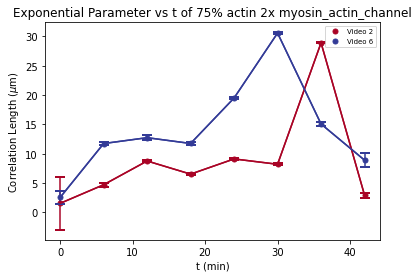

[8, 8, 8, 8, 8]


In [395]:
#correlation length v time

fig, ax = plt.subplots()
#plt.semilogy(time2,1/exp_param_2[:,1],c=cmap(.01),label=str()+'Video 2')

'''Choose which ones are not included'''

plt.plot(time2,1/exp_param_2[:,1],'.',ms=markerSize,c=cmap(.01),label=str()+'Video 2');plt.errorbar(time2,1/exp_param_2[:,1],yerr=exp_param_2[:,2],capsize=5,capthick=2,c=cmap(.01));plt.plot(time2,1/exp_param_2[:,1],c=cmap(.01));
#plt.plot(time3,1/exp_param_3[:,1],'.',ms=markerSize,c=cmap(.15),label=str()+'Video 3');plt.errorbar(time3,1/exp_param_3[:,1],yerr=exp_param_3[:,2],capsize=5,capthick=2,c=cmap(.15));plt.plot(time3,1/exp_param_3[:,1],c=cmap(.15));
#plt.plot(time4,1/exp_param_4[:,1],'.',ms=markerSize,c=cmap(.3),label=str()+'Video 4');plt.errorbar(time4,1/exp_param_4[:,1],yerr=exp_param_4[:,2],capsize=5,capthick=2,c=cmap(.30));plt.plot(time4,1/exp_param_4[:,1],c=cmap(.30));
#plt.plot(time5,1/exp_param_5[:,1],'.',ms=markerSize,c=cmap(.75),label=str()+'Video 5');plt.errorbar(time5,1/exp_param_5[:,1],yerr=exp_param_5[:,2],capsize=5,capthick=2,c=cmap(.75));plt.plot(time5,1/exp_param_5[:,1],c=cmap(.75));
plt.plot(time6,1/exp_param_6[:,1],'.',ms=markerSize,c=cmap(.99),label=str()+'Video 6');plt.errorbar(time6,1/exp_param_6[:,1],yerr=exp_param_6[:,2],capsize=5,capthick=2,c=cmap(.99));plt.plot(time6,1/exp_param_6[:,1],c=cmap(.99));

'''^^^'''

plt.ylabel(r"Correlation Length ($\mu$m)")
plt.xlabel("t (min)")
plt.title("Exponential Parameter vs t of "+finalFileLoc+channel)
#plt.ylim(0,20)
plt.legend(loc=0,fontsize=7)
plt.show()

arry = [exp_param_2.shape[0],exp_param_3.shape[0],exp_param_4.shape[0],exp_param_5.shape[0],
       exp_param_6.shape[0]]
print(arry)
nim = np.argmax(arry)

In [396]:
fig.savefig(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
            +finalFileLoc+"\\"+vid_date+"\\Fits\\"+finalFileLoc+channel+"_correlation_length_exp_fit_chopped.png",dpi=600)

### Choose Which ones are not included within the while loop

[[ 1.53446877  4.70742135  8.7563519   6.51676772  9.10694714  8.19545378
  28.89875887  2.94598547]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 2.54591588 11.73034696 12.72858264 11.74222625 19.49584916 30.5659868
  15.06315233  8.8985015 ]]
[0.71114243 1.87388975 1.40929605 1.61639391 2.27913383 3.34443815
 2.63017172 1.72518347]
[[ 0.          2.04019233  0.71114243]
 [ 6.          8.21888415  1.87388975]
 [12.         10.74246727  1.40929605]
 [18.          9.12949698  1.61639391]
 [24.         14.30139815  2.27913383]
 [30.         19.38072029  3.34443815]
 [36.         21.9809556   2.63017172]
 [42.          5.92224349  1.72518347]]
[[ 0.          3.58410595  0.6777601 ]
 [ 6.         23.7211167   4.24122965]
 [12.         15.47368642  1.56798639

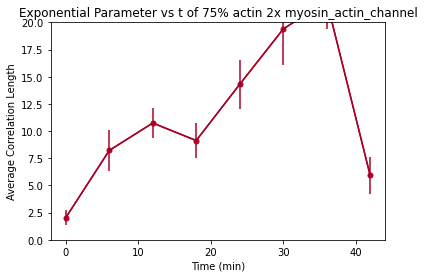

In [397]:
# average correlation length at each time
tx = arry[nim]
matrix = np.zeros((5,tx))
average = np.zeros(tx)
standards = np.zeros(tx)

'''Choose which are included'''
i = 0
while i < matrix.shape[0]:
    for j in range(exp_param_2.shape[0]):
        matrix[i,j] = 1/exp_param_2[j,1]
    i=i+1
#    for j in range(exp_param_3.shape[0]):
#        matrix[i,j] = 1/exp_param_3[j,1]
    i=i+1
#    for j in range(exp_param_4.shape[0]):
#        matrix[i,j] = 1/exp_param_4[j,1]
    i=i+1
#    for j in range(exp_param_5.shape[0]):
#        matrix[i,j] = 1/exp_param_5[j,1]
    i=i+1
    for j in range(exp_param_6.shape[0]):
        matrix[i,j] = 1/exp_param_6[j,1]
    i=i+1

if yes == 1:
    matrixo = np.zeros((5,tx))
    averageo = np.zeros(tx)
    standardso = np.zeros(tx)
    i = 0
    while i < matrixo.shape[0]:
        if matrix[i,0] != 0:
            for j in range(exp_param_2o.shape[0]):
                matrixo[i,j] = 1/exp_param_2o[j,1]
        i=i+1
        if matrix[i,0] != 0:
            for j in range(exp_param_3o.shape[0]):
                matrixo[i,j] = 1/exp_param_3o[j,1]
        i=i+1
        if matrix[i,0] != 0:
            for j in range(exp_param_4o.shape[0]):
                matrixo[i,j] = 1/exp_param_4o[j,1]
        i=i+1
        if matrix[i,0] != 0:
            for j in range(exp_param_5o.shape[0]):
                matrixo[i,j] = 1/exp_param_5o[j,1]
        i=i+1
        if matrix[i,0] != 0:
            for j in range(exp_param_6o.shape[0]):
                matrixo[i,j] = 1/exp_param_6o[j,1]
        i=i+1

print(matrix)
for i in range (len(average)):
    summ1 = 0
    n = 0
    for j in range(matrix.shape[0]):
        if matrix[j,i] != 0:
            summ1 = summ1 + matrix[j,i]
            n = n + 1
    if n != 0:
        average[i] = summ1/n
        summ2 = 0
        int_includ = 0
        for j in range(matrix.shape[0]):
            if matrix[j,i] != 0:
                summ2 = summ2 + np.abs(matrix[j,i] - average[i])
                int_includ = int_includ + 1
        #print(matrix,average)
        if int_includ <= 1:
            standards[i] = 0
        else: standards[i] = np.sqrt(summ2/(int_includ-1))/np.sqrt(int_includ)
print(standards)
nonzero = 0
for i in range(len(average)):
    if average[i] != 0:
        nonzero = nonzero + 1
points = np.zeros(nonzero)
error = np.zeros(nonzero)
ttt = np.linspace(0,(nonzero -1)*6, nonzero)
i = 0
while i < len(average):
    if average[i] != 0:
        points[i] = average[i]
        error[i] = standards[i]
    i = i + 1
matrixttt = np.zeros((len(ttt),3))
matrixttt[:,0] = ttt
matrixttt[:,1] = points
matrixttt[:,2] = error
print(matrixttt)

if yes == 1:
    for i in range (len(averageo)):
        summ1 = 0
        n = 0
        for j in range(matrixo.shape[0]):
            if matrixo[j,i] != 0:
                summ1 = summ1 + matrixo[j,i]
                n = n + 1
        if n != 0:
            averageo[i] = summ1/n
            summ2 = 0
            int_includ = 0
            for j in range(matrixo.shape[0]):
                if matrixo[j,i] != 0:
                    summ2 = summ2 + np.abs(matrixo[j,i] - averageo[i])
                    int_includ = int_includ + 1
            #print(matrix,average)
            if int_includ <= 1:
                standardso[i] = 0
            else: standardso[i] = np.sqrt(summ2/(int_includ-1))/np.sqrt(int_includ)
    #print(standardso)
    nonzeroo = 0
    for i in range(len(averageo)):
        if averageo[i] != 0:
            nonzeroo = nonzeroo + 1
    pointso = np.zeros(nonzeroo)
    erroro = np.zeros(nonzeroo)
    ttto = np.linspace(0,(nonzeroo -1)*6, nonzeroo)
    i = 0
    while i < len(averageo):
        if averageo[i] != 0:
            pointso[i] = averageo[i]
            erroro[i] = standardso[i]
        i = i + 1
    matrixttto = np.zeros((len(ttto),3))
    matrixttto[:,0] = ttto
    matrixttto[:,1] = pointso
    matrixttto[:,2] = erroro
    print(matrixttto)
fig, ax = plt.subplots()

#75A = 0.01,20A = .15, even = .3,.5M=.75,2M=.99
color = 1
if finalFileLoc == '0.5x myosin':color = .75;
elif finalFileLoc == '2x myosin':color = .99;
elif finalFileLoc == '25%actin':color = .15;
elif finalFileLoc == '50% actin 1x myosin':color = .3;
elif finalFileLoc == '75%actin':color = .01;
print(color)

plt.plot(ttt,points,c=cmap(color))
plt.plot(ttt,points,'.',ms=markerSize,c=cmap(color))
plt.errorbar(ttt,points,yerr=error,c=cmap(color))
plt.title("Exponential Parameter vs t of "+finalFileLoc+channel)
plt.xlabel("Time (min)")
plt.ylabel("Average Correlation Length")
plt.ylim(0,20)
plt.show()

savetxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
            +finalFileLoc+"\\"+vid_date+"\\Fits\\"+finalFileLoc+channel+"_average_correlation_length_exp_fit_"
        +"chopped.csv",matrixttt,delimiter=',')
#print(matrix)
#print(matrixo)

In [398]:
fig.savefig(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
            +finalFileLoc+"\\"+vid_date+"\\Fits\\"+finalFileLoc+channel+"_average_correlation_length_exp_fit_"+
            "chopped.png",dpi=600)

1


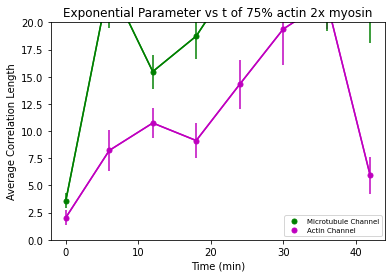

In [401]:
fig, ax = plt.subplots()

#75A = 0.01,20A = .15, even = .3,.5M=.75,2M=.99
color = 1
coloro = 0
if finalFileLoc == '0.5x myosin':color = .75;coloro=1-color;
elif finalFileLoc == '2x myosin':color = .99;coloro=1-color;
elif finalFileLoc == '25%actin':color = .15;coloro=1-color;
elif finalFileLoc == '50% actin 1x myosin':color = .3;coloro=1-color;
elif finalFileLoc == '75%actin':color = .01;coloro=1-color;
print(color)

rg = 0
rg=1                  #comment out if want regular color map
if rg == 1:
    if text2[-1] == "0":
        color = 'm';coloro = 'g';
    else:color = 'g';coloro = 'm';
plt.plot(ttt,points,c=color)                                 #c=cmap(color)
plt.errorbar(ttt,points,yerr=error,c=color)         #c=cmap(color)

if text2[-1] == '0':
    plt.plot(ttto,pointso,'.',ms=markerSize,c=coloro,label=str()+'Microtubule Channel')
    plt.plot(ttt,points,'.',ms=markerSize,c=color,label=str()+'Actin Channel')
else:
    plt.plot(ttto,pointso,'.',ms=markerSize,c=coloro,label=str()+'Actin Channel')
    plt.plot(ttt,points,'.',ms=markerSize,c=color,label=str()+'Microtubule Channel')

plt.plot(ttto,pointso,c=coloro)
plt.errorbar(ttto,pointso,yerr=erroro,c=coloro)
plt.title("Exponential Parameter vs t of "+finalFileLoc)
plt.xlabel("Time (min)")
plt.ylabel("Average Correlation Length")
plt.legend(loc=0,fontsize=7)
plt.ylim(0,20)
plt.show()

In [402]:
fig.savefig(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
            +finalFileLoc+"\\"+vid_date+"\\Fits\\"+finalFileLoc+"_both_channels_average_correlation_length_exp_fit_"+
            "chopped.png",dpi=600)

## All Experiments Summary

[[ 0.          1.88719339  0.19628525]
 [ 6.          2.96397445  0.53404264]
 [12.          4.5871662   0.96741403]
 [18.          4.9145874   0.89671999]
 [24.          4.3041249   0.68828304]
 [30.          4.4981736   0.65831849]
 [36.          5.63424895  1.4568663 ]
 [42.          7.12161103  1.57440781]]


<Figure size 432x288 with 0 Axes>

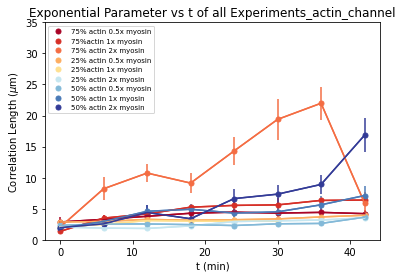

In [418]:
chan = 0
if chan == 1:
    channel = "_actin_channel"
else:
    channel = "_microtubule_channel"

fityA1xMy = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"+
                           "50% actin 1x myosin\\20200910\\Fits\\50% actin 1x myosin"+channel+"_average_correlation_length_exp_fit_"+
                      "chopped.csv", delimiter=',')
twenA1xMy = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"+
                           "25%actin\\20200909\\Fits\\25%actin"+channel+"_average_correlation_length_exp_fit_"+
                      "chopped.csv", delimiter=',')
svenA1xMy = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"+
                           "75%actin\\20200805\\Fits\\75%actin"+channel+"_average_correlation_length_exp_fit_"+
                      "chopped.csv", delimiter=',')
fityAp5xMy = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"+
                           "0.5x myosin\\20200908\\Fits\\0.5x myosin"+channel+"_average_correlation_length_exp_fit_"+
                      "chopped.csv", delimiter=',')
fityA2xMy = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"+
                           "2x myosin\\20200807\\Fits\\2x myosin"+channel+"_average_correlation_length_exp_fit_"+
                      "chopped.csv", delimiter=',')
twenA2xMy = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"+
                           "25% actin 2x myosin\\20201215\\Fits\\25% actin 2x myosin"+channel+"_average_correlation_length_exp_fit_"+
                      "chopped.csv", delimiter=',')
svenAp5xMy = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"+
                           "75% actin 0.5x myosin\\20201218\\Fits\\75% actin 0.5x myosin"+channel+"_average_correlation_length_exp_fit_"+
                      "chopped.csv", delimiter=',')
twenAp5xMy = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"+
                           "25% actin 0.5x myosin\\20210401\\Fits\\25% actin 0.5x myosin"+channel+"_average_correlation_length_exp_fit_"+
                      "chopped.csv", delimiter=',')
svenA2xMy = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"+
                           "75% actin 2x myosin\\20210330\\Fits\\75% actin 2x myosin"+channel+"_average_correlation_length_exp_fit_"+
                      "chopped.csv", delimiter=',')

chano=10
chano = chan                                               #comment out to ignore doing both
if chano != 10:
    if chan == 0:
        chano = 1
        channelo = "_actin_channel"
    else:
        chano = 0
        channelo = "_microtubule_channel"
    fityA1xMyo = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"+
                               "50% actin 1x myosin\\20200910\\Fits\\50% actin 1x myosin"+channelo+"_average_correlation_length_exp_fit_"+
                          "chopped.csv", delimiter=',')
    twenA1xMyo = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"+
                               "25%actin\\20200909\\Fits\\25%actin"+channelo+"_average_correlation_length_exp_fit_"+
                          "chopped.csv", delimiter=',')
    svenA1xMyo = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"+
                               "75%actin\\20200805\\Fits\\75%actin"+channelo+"_average_correlation_length_exp_fit_"+
                          "chopped.csv", delimiter=',')
    fityAp5xMyo = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"+
                               "0.5x myosin\\20200908\\Fits\\0.5x myosin"+channelo+"_average_correlation_length_exp_fit_"+
                          "chopped.csv", delimiter=',')
    fityA2xMyo = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"+
                               "2x myosin\\20200807\\Fits\\2x myosin"+channelo+"_average_correlation_length_exp_fit_"+
                          "chopped.csv", delimiter=',')
    twenA2xMyo = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"+
                           "25% actin 2x myosin\\20201215\\Fits\\25% actin 2x myosin"+channelo+"_average_correlation_length_exp_fit_"+
                      "chopped.csv", delimiter=',')
    svenAp5xMyo = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"+
                           "75% actin 0.5x myosin\\20201218\\Fits\\75% actin 0.5x myosin"+channelo+"_average_correlation_length_exp_fit_"+
                      "chopped.csv", delimiter=',')
    twenAp5xMyo = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"+
                           "25% actin 0.5x myosin\\20210401\\Fits\\25% actin 0.5x myosin"+channelo+"_average_correlation_length_exp_fit_"+
                      "chopped.csv", delimiter=',')
    svenA2xMyo = loadtxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"+
                           "75% actin 2x myosin\\20210330\\Fits\\75% actin 2x myosin"+channelo+"_average_correlation_length_exp_fit_"+
                      "chopped.csv", delimiter=',')

print(fityA1xMy)
plt.figure()

fig, ax = plt.subplots()
#plt.semilogy(time2,1/exp_param_2[:,1],c=cmap(.01),label=str()+'Video 2')
plt.plot(svenAp5xMy[:,0],svenAp5xMy[:,1],'.',ms=markerSize,c=cmap(.01),label=str()+'75% actin 0.5x myosin')
plt.plot(svenA1xMy[:,0],svenA1xMy[:,1],'.',ms=markerSize,c=cmap(.1),label=str()+'75%actin 1x myosin')
plt.plot(svenA2xMy[:,0],svenA2xMy[:,1],'.',ms=markerSize,c=cmap(.2),label=str()+'75% actin 2x myosin')
plt.plot(twenAp5xMy[:,0],twenAp5xMy[:,1],'.',ms=markerSize,c=cmap(.3),label=str()+'25% actin 0.5x myosin')
plt.plot(twenA1xMy[:,0],twenA1xMy[:,1],'.',ms=markerSize,c=cmap(.4),label=str()+'25%actin 1x myosin')
plt.plot(twenA2xMy[:,0],twenA2xMy[:,1],'.',ms=markerSize,c=cmap(.65),label=str()+'25% actin 2x myosin')
plt.plot(fityAp5xMy[:,0],fityAp5xMy[:,1],'.',ms=markerSize,c=cmap(.77),label=str()+'50% actin 0.5x myosin')
plt.plot(fityA1xMy[:,0],fityA1xMy[:,1],'.',ms=markerSize,c=cmap(.89),label=str()+'50% actin 1x myosin')
plt.plot(fityA2xMy[:,0],fityA2xMy[:,1],'.',ms=markerSize,c=cmap(.99),label=str()+'50% actin 2x myosin')

plt.errorbar(svenAp5xMy[:,0],svenAp5xMy[:,1],yerr=svenAp5xMy[:,2],c=cmap(.01))
plt.errorbar(svenA1xMy[:,0],svenA1xMy[:,1],yerr=svenA1xMy[:,2],c=cmap(.1))
plt.errorbar(svenA2xMy[:,0],svenA2xMy[:,1],yerr=svenA2xMy[:,2],c=cmap(.2))
plt.errorbar(twenAp5xMy[:,0],twenAp5xMy[:,1],yerr=twenAp5xMy[:,2],c=cmap(.3))
plt.errorbar(twenA1xMy[:,0],twenA1xMy[:,1],yerr=twenA1xMy[:,2],c=cmap(.4))
plt.errorbar(twenA2xMy[:,0],twenA2xMy[:,1],yerr=twenA2xMy[:,2],c=cmap(.65))
plt.errorbar(fityAp5xMy[:,0],fityAp5xMy[:,1],yerr=fityAp5xMy[:,2],c=cmap(.77))
plt.errorbar(fityA1xMy[:,0],fityA1xMy[:,1],yerr=fityA1xMy[:,2],c=cmap(.89))
plt.errorbar(fityA2xMy[:,0],fityA2xMy[:,1],yerr=fityA2xMy[:,2],c=cmap(.99))

plt.plot(svenAp5xMy[:,0],svenAp5xMy[:,1],c=cmap(.01))
plt.plot(svenA1xMy[:,0],svenA1xMy[:,1],c=cmap(.1))
plt.plot(svenA2xMy[:,0],svenA2xMy[:,1],c=cmap(.2))
plt.plot(twenAp5xMy[:,0],twenAp5xMy[:,1],c=cmap(.3))
plt.plot(twenA1xMy[:,0],twenA1xMy[:,1],c=cmap(.4))
plt.plot(twenA2xMy[:,0],twenA2xMy[:,1],c=cmap(.65))
plt.plot(fityAp5xMy[:,0],fityAp5xMy[:,1],c=cmap(.77))
plt.plot(fityA1xMy[:,0],fityA1xMy[:,1],c=cmap(.89))
plt.plot(fityA2xMy[:,0],fityA2xMy[:,1],c=cmap(.99))
plt.ylabel(r"Correlation Length ($\mu$m)")
plt.xlabel("t (min)")
plt.title("Exponential Parameter vs t of all Experiments"+str(channel))
plt.legend(loc=0,fontsize=7)
plt.ylim(0,35)
plt.show()

svenA1xMy = np.array(svenA1xMy)
twenA1xMy = np.array(twenA1xMy)
fityAp5xMy = np.array(fityAp5xMy)
fityA2xMy = np.array(fityA2xMy)
twenA2xMy = np.array(twenA2xMy)
svenAp5xMy = np.array(svenAp5xMy)
twenAp5xMy = np.array(twenAp5xMy)
svenA2xMy = np.array(svenA2xMy)

In [419]:
fig.savefig(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
            +"\\Fits\\All_Experiments"+channel+"_average_correlation_length_exp_fit_"+
            "chopped.png",dpi=600)

In [420]:
'''
text_data = np.empty((8,10))
for i in range(8):
    text_data[i,0] = svenA1xMy[i,0]
    text_data[i,1] = svenA1xMy[i,1]
for i in range(6):
    text_data[i,2] = twenA1xMy[i,0]
    text_data[i,3] = twenA1xMy[i,1]
for i in range(8):
    text_data[i,4] = fityA1xMy[i,0]
    text_data[i,5] = fityA1xMy[i,1]
for i in range(8):
    text_data[i,6] = fityAp5xMy[i,0]
    text_data[i,7] = fityAp5xMy[i,1]
for i in range(8):
    text_data[i,8] = fityA2xMy[i,0]
    text_data[i,9] = fityA2xMy[i,1]
for i in range(1,text_data.shape[0]):
    for j in range(1,text_data.shape[1]):
        if text_data[i,j] == 0:
            text_data[i,j] = np.nan;

[svenA1xMy[:,0],svenA1xMy[:,1],twenA1xMy[:,0],twenA1xMy[:,1],
             fityA1xMy[:,0],fityA1xMy[:,1],fityAp5xMy[:,0],fityAp5xMy[:,1],
             fityA2xMy[:,0],fityA2xMy[:,1]]
'''
text_data = np.empty((8,37))
contract = np.empty((8,17))
nocontract = np.empty((8,13))
for i in range(8):
    text_data[i,1] = svenAp5xMy[i,1]
    text_data[i,2] = svenAp5xMy[i,2]
    text_data[i,3] = svenAp5xMyo[i,1]
    text_data[i,4] = svenAp5xMyo[i,2]
for i in range(8):
    text_data[i,0] = svenA1xMy[i,0]
    text_data[i,5] = svenA1xMy[i,1]
    text_data[i,6] = svenA1xMy[i,2]
    text_data[i,7] = svenA1xMyo[i,1]
    text_data[i,8] = svenA1xMyo[i,2]
for i in range(8):
    text_data[i,9] = svenA2xMy[i,1]
    text_data[i,10] = svenA2xMy[i,2]
    text_data[i,11] = svenA2xMyo[i,1]
    text_data[i,12] = svenA2xMyo[i,2]
for i in range(8):
    text_data[i,13] = twenAp5xMy[i,1]
    text_data[i,14] = twenAp5xMy[i,2]
    text_data[i,15] = twenAp5xMyo[i,1]
    text_data[i,16] = twenAp5xMyo[i,2]
for i in range(6):
    text_data[i,17] = twenA1xMy[i,1]
    text_data[i,18] = twenA1xMy[i,2]
    text_data[i,19] = twenA1xMyo[i,1]
    text_data[i,20] = twenA1xMyo[i,2]
for i in range(8):
    text_data[i,21] = twenA2xMy[i,1]
    text_data[i,22] = twenA2xMy[i,2]
    text_data[i,23] = twenA2xMyo[i,1]
    text_data[i,24] = twenA2xMyo[i,2]
for i in range(8):
    text_data[i,25] = fityAp5xMy[i,1]
    text_data[i,26] = fityAp5xMy[i,2]
    text_data[i,27] = fityAp5xMyo[i,1]
    text_data[i,28] = fityAp5xMyo[i,2]
for i in range(8):
    text_data[i,29] = fityA1xMy[i,1]
    text_data[i,30] = fityA1xMy[i,2]
    text_data[i,31] = fityA1xMyo[i,1]
    text_data[i,32] = fityA1xMyo[i,2]
for i in range(8):
    text_data[i,33] = fityA2xMy[i,1]
    text_data[i,34] = fityA2xMy[i,2]
    text_data[i,35] = fityA2xMyo[i,1]
    text_data[i,36] = fityA2xMyo[i,2]
for i in range(1,text_data.shape[0]):
    for j in range(1,text_data.shape[1]):
        if text_data[i,j] <=.0001 or text_data[i,j] > 5000:
            text_data[i,j] = np.nan;
print(text_data)
savetxt(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
            +"\\Fits\\Exponential_Param_all_experiments_average_correlation_length_exp_fit_"
        +"chopped.csv",text_data,delimiter=',')

[[ 0.          2.87131734  0.82557472  3.71733233  0.69026309  1.36258834
   0.14120789  2.78901285  0.51963436  2.04019233  0.71114243  3.58410595
   0.6777601   2.86958108  0.31747998  3.34588161  0.47694297  2.077862
   0.25101211  3.03352661  0.17745193  2.05352435  0.3702212   1.84495414
   0.31737696  2.33881074  0.22199334  2.90679193  0.17871693  1.88719339
   0.19628525  3.48958431  0.2604951   1.96012386  0.3236438   4.00332502
   0.32548642]
 [ 6.          3.2949425   0.66430081  5.12875267  0.5426451   3.4884374
   0.56753486  6.60791252  0.56321221  8.21888415  1.87388975 23.7211167
   4.24122965  2.94821886  0.46602548  2.88609007  0.48897157  2.48107239
   0.2920426   3.77187132  0.455116    1.8782577   0.3153056   1.80449878
   0.3201874   2.53982615  0.27889817  2.75620481  0.28883713  2.96397445
   0.53404264  4.85186801  0.69993206  2.56510145  0.6297323   4.53909121
   0.65206182]
 [12.          3.78374694  0.54934466  5.841146    0.47760337  4.17190196
   0.5745746

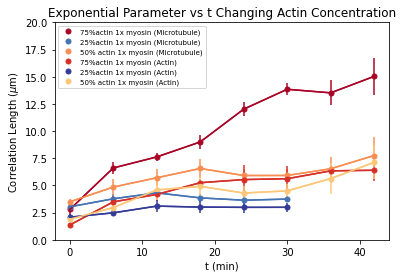

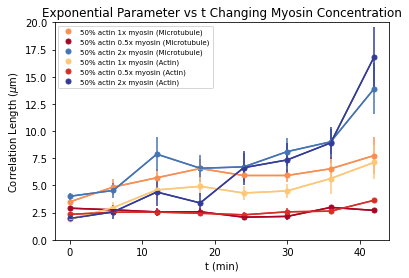

In [37]:
if chano != chan:
    two = " (Microtubule)"
    one = " (Actin)"
    if chan == 1:
        one = " (Microtubule)"
        two = " (Actin)"
    fig1, ax = plt.subplots()
    #plt.semilogy(time2,1/exp_param_2[:,1],c=cmap(.01),label=str()+'Video 2')
    plt.plot(svenA1xMy[:,0],svenA1xMy[:,1],'.',ms=markerSize,c=cmap(.01),label=str()+'75%actin 1x myosin' + one)
    plt.plot(twenA1xMy[:,0],twenA1xMy[:,1],'.',ms=markerSize,c=cmap(.9),label=str()+'25%actin 1x myosin' + one)
    plt.plot(fityA1xMy[:,0],fityA1xMy[:,1],'.',ms=markerSize,c=cmap(.25),label=str()+'50% actin 1x myosin' + one)
    plt.plot(svenA1xMyo[:,0],svenA1xMyo[:,1],'.',ms=markerSize,c=cmap(.1),label=str()+'75%actin 1x myosin' + two)
    plt.plot(twenA1xMyo[:,0],twenA1xMyo[:,1],'.',ms=markerSize,c=cmap(.99),label=str()+'25%actin 1x myosin' + two)
    plt.plot(fityA1xMyo[:,0],fityA1xMyo[:,1],'.',ms=markerSize,c=cmap(.35),label=str()+'50% actin 1x myosin' + two)

    plt.errorbar(svenA1xMy[:,0],svenA1xMy[:,1],yerr=svenA1xMy[:,2],c=cmap(.01))
    plt.errorbar(twenA1xMy[:,0],twenA1xMy[:,1],yerr=twenA1xMy[:,2],c=cmap(.9))
    plt.errorbar(fityA1xMy[:,0],fityA1xMy[:,1],yerr=fityA1xMy[:,2],c=cmap(.25))
    plt.errorbar(svenA1xMyo[:,0],svenA1xMyo[:,1],yerr=svenA1xMyo[:,2],c=cmap(.1))
    plt.errorbar(twenA1xMyo[:,0],twenA1xMyo[:,1],yerr=twenA1xMyo[:,2],c=cmap(.99))
    plt.errorbar(fityA1xMyo[:,0],fityA1xMyo[:,1],yerr=fityA1xMyo[:,2],c=cmap(.35))

    plt.plot(svenA1xMy[:,0],svenA1xMy[:,1],c=cmap(.01))
    plt.plot(twenA1xMy[:,0],twenA1xMy[:,1],c=cmap(.9))
    plt.plot(fityA1xMy[:,0],fityA1xMy[:,1],c=cmap(.25))
    plt.plot(svenA1xMyo[:,0],svenA1xMyo[:,1],c=cmap(.1))
    plt.plot(twenA1xMyo[:,0],twenA1xMyo[:,1],c=cmap(.99))
    plt.plot(fityA1xMyo[:,0],fityA1xMyo[:,1],c=cmap(.35))
    plt.ylabel(r"Correlation Length ($\mu$m)")
    plt.xlabel("t (min)")
    plt.title("Exponential Parameter vs t Changing Actin Concentration")
    plt.legend(loc=0,fontsize=7)
    plt.ylim(0,20)
    plt.show()

    fig2, ax = plt.subplots()
    #plt.semilogy(time2,1/exp_param_2[:,1],c=cmap(.01),label=str()+'Video 2')
    plt.plot(fityA1xMy[:,0],fityA1xMy[:,1],'.',ms=markerSize,c=cmap(.25),label=str()+'50% actin 1x myosin' + one)
    plt.plot(fityAp5xMy[:,0],fityAp5xMy[:,1],'.',ms=markerSize,c=cmap(.01),label=str()+'50% actin 0.5x myosin' + one)
    plt.plot(fityA2xMy[:,0],fityA2xMy[:,1],'.',ms=markerSize,c=cmap(.9),label=str()+'50% actin 2x myosin' + one)
    plt.plot(fityA1xMyo[:,0],fityA1xMyo[:,1],'.',ms=markerSize,c=cmap(.35),label=str()+'50% actin 1x myosin' + two)
    plt.plot(fityAp5xMyo[:,0],fityAp5xMyo[:,1],'.',ms=markerSize,c=cmap(.1),label=str()+'50% actin 0.5x myosin' + two)
    plt.plot(fityA2xMyo[:,0],fityA2xMyo[:,1],'.',ms=markerSize,c=cmap(.99),label=str()+'50% actin 2x myosin' + two)

    plt.errorbar(fityA1xMy[:,0],fityA1xMy[:,1],yerr=fityA1xMy[:,2],c=cmap(.25))
    plt.errorbar(fityAp5xMy[:,0],fityAp5xMy[:,1],yerr=fityAp5xMy[:,2],c=cmap(.01))
    plt.errorbar(fityA2xMy[:,0],fityA2xMy[:,1],yerr=fityA2xMy[:,2],c=cmap(.9))
    plt.errorbar(fityA1xMyo[:,0],fityA1xMyo[:,1],yerr=fityA1xMyo[:,2],c=cmap(.35))
    plt.errorbar(fityAp5xMyo[:,0],fityAp5xMyo[:,1],yerr=fityAp5xMyo[:,2],c=cmap(.1))
    plt.errorbar(fityA2xMyo[:,0],fityA2xMyo[:,1],yerr=fityA2xMyo[:,2],c=cmap(.99))

    plt.plot(fityA1xMy[:,0],fityA1xMy[:,1],c=cmap(.25))
    plt.plot(fityAp5xMy[:,0],fityAp5xMy[:,1],c=cmap(.01))
    plt.plot(fityA2xMy[:,0],fityA2xMy[:,1],c=cmap(.9))
    plt.plot(fityA1xMyo[:,0],fityA1xMyo[:,1],c=cmap(.35))
    plt.plot(fityAp5xMyo[:,0],fityAp5xMyo[:,1],c=cmap(.1))
    plt.plot(fityA2xMyo[:,0],fityA2xMyo[:,1],c=cmap(.99))
    plt.ylabel(r"Correlation Length ($\mu$m)")
    plt.xlabel("t (min)")
    plt.title("Exponential Parameter vs t Changing Myosin Concentration")
    plt.legend(loc=0,fontsize=7)
    plt.ylim(0,20)
    plt.show()

In [109]:
fig1.savefig(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
            +"\\Fits\\Changing_Actin_conc_average_correlation_length_exp_fit_"+
            "chopped.png",dpi=600)
fig2.savefig(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
            +"\\Fits\\Changing_Myosin_conc_average_correlation_length_exp_fit_"+
            "chopped.png",dpi=600)

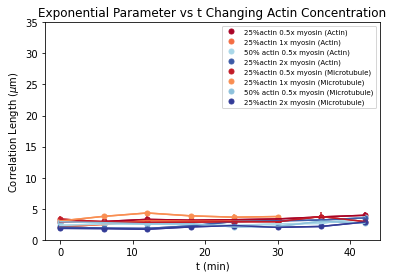

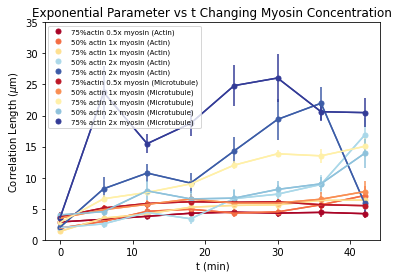

In [416]:
if chano != chan:
    two = " (Microtubule)"
    one = " (Actin)"
    if chan == 1:
        one = " (Microtubule)"
        two = " (Actin)"
    fig1, ax = plt.subplots()
    #plt.semilogy(time2,1/exp_param_2[:,1],c=cmap(.01),label=str()+'Video 2')
    plt.plot(twenAp5xMy[:,0],twenAp5xMy[:,1],'.',ms=markerSize,c=cmap(.01),label=str()+'25%actin 0.5x myosin' + one)
    plt.plot(twenA1xMy[:,0],twenA1xMy[:,1],'.',ms=markerSize,c=cmap(.2),label=str()+'25%actin 1x myosin' + one)
    plt.plot(fityAp5xMy[:,0],fityAp5xMy[:,1],'.',ms=markerSize,c=cmap(.7),label=str()+'50% actin 0.5x myosin' + one)
    plt.plot(twenA2xMy[:,0],twenA2xMy[:,1],'.',ms=markerSize,c=cmap(.94),label=str()+'25%actin 2x myosin' + one)
    plt.plot(twenAp5xMyo[:,0],twenAp5xMyo[:,1],'.',ms=markerSize,c=cmap(.06),label=str()+'25%actin 0.5x myosin' + two)
    plt.plot(twenA1xMyo[:,0],twenA1xMyo[:,1],'.',ms=markerSize,c=cmap(.25),label=str()+'25%actin 1x myosin' + two)
    plt.plot(fityAp5xMyo[:,0],fityAp5xMyo[:,1],'.',ms=markerSize,c=cmap(.75),label=str()+'50% actin 0.5x myosin' + two)
    plt.plot(twenA2xMyo[:,0],twenA2xMyo[:,1],'.',ms=markerSize,c=cmap(.99),label=str()+'25%actin 2x myosin' + two)

    plt.errorbar(twenAp5xMy[:,0],twenAp5xMy[:,1],yerr=twenAp5xMy[:,2],c=cmap(.01))
    plt.errorbar(twenA1xMy[:,0],twenA1xMy[:,1],yerr=twenA1xMy[:,2],c=cmap(.2))
    plt.errorbar(fityAp5xMy[:,0],fityAp5xMy[:,1],yerr=fityAp5xMy[:,2],c=cmap(.7))
    plt.errorbar(twenA2xMy[:,0],twenA2xMy[:,1],yerr=twenA2xMy[:,2],c=cmap(.94))
    plt.errorbar(twenAp5xMyo[:,0],twenAp5xMyo[:,1],yerr=twenAp5xMyo[:,2],c=cmap(.06))
    plt.errorbar(twenA1xMyo[:,0],twenA1xMyo[:,1],yerr=twenA1xMyo[:,2],c=cmap(.25))
    plt.errorbar(fityAp5xMyo[:,0],fityAp5xMyo[:,1],yerr=fityAp5xMyo[:,2],c=cmap(.75))
    plt.errorbar(twenA2xMyo[:,0],twenA2xMyo[:,1],yerr=twenA2xMyo[:,2],c=cmap(.99))

    plt.plot(twenAp5xMy[:,0],twenAp5xMy[:,1],c=cmap(.01))
    plt.plot(twenA1xMy[:,0],twenA1xMy[:,1],c=cmap(.2))
    plt.plot(fityAp5xMy[:,0],fityAp5xMy[:,1],c=cmap(.7))
    plt.plot(twenA2xMy[:,0],twenA2xMy[:,1],c=cmap(.94))
    plt.plot(twenAp5xMyo[:,0],twenAp5xMyo[:,1],c=cmap(.06))
    plt.plot(twenA1xMyo[:,0],twenA1xMyo[:,1],c=cmap(.25))
    plt.plot(fityAp5xMyo[:,0],fityAp5xMyo[:,1],c=cmap(.75))
    plt.plot(twenA2xMyo[:,0],twenA2xMyo[:,1],c=cmap(.99))
    plt.ylabel(r"Correlation Length ($\mu$m)")
    plt.xlabel("t (min)")
    plt.title("Exponential Parameter vs t Changing Actin Concentration")
    plt.legend(loc=0,fontsize=7)
    plt.ylim(0,35)
    plt.show()

    fig2, ax = plt.subplots()
    #plt.semilogy(time2,1/exp_param_2[:,1],c=cmap(.01),label=str()+'Video 2')
    plt.plot(svenAp5xMy[:,0],svenAp5xMy[:,1],'.',ms=markerSize,c=cmap(.01),label=str()+'75%actin 0.5x myosin' + one)
    plt.plot(fityA1xMy[:,0],fityA1xMy[:,1],'.',ms=markerSize,c=cmap(.2),label=str()+'50% actin 1x myosin' + one)
    plt.plot(svenA1xMy[:,0],svenA1xMy[:,1],'.',ms=markerSize,c=cmap(.4),label=str()+'75% actin 1x myosin' + one)
    plt.plot(fityA2xMy[:,0],fityA2xMy[:,1],'.',ms=markerSize,c=cmap(.7),label=str()+'50% actin 2x myosin' + one)
    plt.plot(svenA2xMy[:,0],svenA2xMy[:,1],'.',ms=markerSize,c=cmap(.94),label=str()+'75% actin 2x myosin' + one)
    plt.plot(svenAp5xMyo[:,0],svenAp5xMyo[:,1],'.',ms=markerSize,c=cmap(.05),label=str()+'75%actin 0.5x myosin' + two)
    plt.plot(fityA1xMyo[:,0],fityA1xMyo[:,1],'.',ms=markerSize,c=cmap(.25),label=str()+'50% actin 1x myosin' + two)
    plt.plot(svenA1xMyo[:,0],svenA1xMyo[:,1],'.',ms=markerSize,c=cmap(.45),label=str()+'75% actin 1x myosin' + two)
    plt.plot(fityA2xMyo[:,0],fityA2xMyo[:,1],'.',ms=markerSize,c=cmap(.75),label=str()+'50% actin 2x myosin' + two)
    plt.plot(svenA2xMyo[:,0],svenA2xMyo[:,1],'.',ms=markerSize,c=cmap(.99),label=str()+'75% actin 2x myosin' + two)
    
    plt.errorbar(svenAp5xMy[:,0],svenAp5xMy[:,1],yerr=svenAp5xMy[:,2],c=cmap(.01))
    plt.errorbar(fityA1xMy[:,0],fityA1xMy[:,1],yerr=fityA1xMy[:,2],c=cmap(.2))
    plt.errorbar(svenA1xMy[:,0],svenA1xMy[:,1],yerr=svenA1xMy[:,2],c=cmap(.4))
    plt.errorbar(fityA2xMy[:,0],fityA2xMy[:,1],yerr=fityA2xMy[:,2],c=cmap(.7))
    plt.errorbar(svenA2xMy[:,0],svenA2xMy[:,1],yerr=svenA2xMy[:,2],c=cmap(.94))
    plt.errorbar(svenAp5xMyo[:,0],svenAp5xMyo[:,1],yerr=svenAp5xMyo[:,2],c=cmap(.05))
    plt.errorbar(fityA1xMyo[:,0],fityA1xMyo[:,1],yerr=fityA1xMyo[:,2],c=cmap(.25))
    plt.errorbar(svenA1xMyo[:,0],svenA1xMyo[:,1],yerr=svenA1xMyo[:,2],c=cmap(.45))
    plt.errorbar(fityA2xMyo[:,0],fityA2xMyo[:,1],yerr=fityA2xMyo[:,2],c=cmap(.75))
    plt.errorbar(svenA2xMyo[:,0],svenA2xMyo[:,1],yerr=svenA2xMyo[:,2],c=cmap(.99))
    
    plt.plot(svenAp5xMy[:,0],svenAp5xMy[:,1],c=cmap(.01))
    plt.plot(fityA1xMy[:,0],fityA1xMy[:,1],c=cmap(.2))
    plt.plot(svenA1xMy[:,0],svenA1xMy[:,1],c=cmap(.4))
    plt.plot(fityA2xMy[:,0],fityA2xMy[:,1],c=cmap(.7))
    plt.plot(svenA2xMy[:,0],svenA2xMy[:,1],c=cmap(.9))
    plt.plot(svenAp5xMyo[:,0],svenAp5xMyo[:,1],c=cmap(.05))
    plt.plot(fityA1xMyo[:,0],fityA1xMyo[:,1],c=cmap(.25))
    plt.plot(svenA1xMyo[:,0],svenA1xMyo[:,1],c=cmap(.45))
    plt.plot(fityA2xMyo[:,0],fityA2xMyo[:,1],c=cmap(.75))
    plt.plot(svenA2xMyo[:,0],svenA2xMyo[:,1],c=cmap(.99))
    plt.ylabel(r"Correlation Length ($\mu$m)")
    plt.xlabel("t (min)")
    plt.title("Exponential Parameter vs t Changing Myosin Concentration")
    plt.legend(loc=0,fontsize=7)
    plt.ylim(0,35)
    plt.show()

In [ ]:
fig1.savefig(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
            +"\\Fits\\Non_contracting_average_correlation_length_exp_fit_"+
            "chopped.png",dpi=600)
fig2.savefig(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Data\\"
            +"\\Fits\\Contracting_average_correlation_length_exp_fit_"+
            "chopped.png",dpi=600)

<ipython-input-32-54e7d9634786>:13: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(-0.04,0.9)


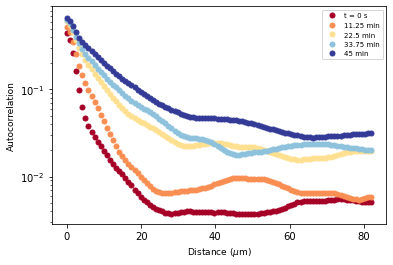

In [32]:
#attempt at fitting
plt.figure()
plt.semilogy(xvalues, gf1d(corr_ravs[0],gf1dsize),'.',ms=markerSize,c=cmap(0),label="t = 0 s")
plt.semilogy(xvalues, gf1d(corr_ravs[1],gf1dsize),'.',ms=markerSize,c=cmap(0.25),label='11.25 min')
plt.semilogy(xvalues, gf1d(corr_ravs[2],gf1dsize),'.',ms=markerSize,c=cmap(0.4),label='22.5 min')
plt.semilogy(xvalues, gf1d(corr_ravs[3],gf1dsize),'.',ms=markerSize,c=cmap(0.75),label='33.75 min')
plt.semilogy(xvalues, gf1d(corr_ravs[4],gf1dsize),'.',ms=markerSize,c=cmap(0.99),label='45 min')
plt.legend(loc=0,fontsize=7)
plt.xlabel("Distance ($\mu$m)",fontsize=9)
plt.ylabel("Autocorrelation",fontsize=9)
plt.legend(loc=0,fontsize=7)
#plt.locator_params(axis='y', nbins=5)
plt.ylim(-0.04,0.9)
plt.savefig(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"+finalFileLoc+"\\"+vid_date+"\\"
        +data_file+"_semilogy_autocorrelation"+length+".png",dpi=600)
plt.show()

In [33]:
plt.savefig(directory+":\\Chris\\Spatial Image Analysis\\ImageAutocorrelation\\Correlation Graphs\\"+finalFileLoc+"\\"
        +data_file+"_loglog_autocorrelation"+length+".png",dpi=600)

<Figure size 432x288 with 0 Axes>

In [34]:
data_dir = "Y:\\Jon_Garamella\\data\\active_networks\\videos_date\\2020-06-17\\AMT\\yesmyosin\\20200617_LK16YOYO_AMT_568A_RT_samespot3\\"
data_file = "20200617_LK16YOYO_AMT_568A_RT_samespot3_MMStack_Pos0.ome.tif"

In [35]:
ims = tiff_file.imread(data_dir+data_file,key=[0,250])
print("Shape of ims is %i,%i,%i" % ims.shape)
print("So %i frames of %ix%i pixels each" % ims.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'Y:\\Jon_Garamella\\data\\active_networks\\videos_date\\2020-06-17\\AMT\\yesmyosin\\20200617_LK16YOYO_AMT_568A_RT_samespot3\\20200617_LK16YOYO_AMT_568A_RT_samespot3_MMStack_Pos0.ome.tif'

In [ ]:
xstart = 0
xstop = 256
ystart = 0
ystop = 256


plt.matshow(ims[1,ystart:ystop,xstart:xstop])

In [ ]:
ims_new = ims[:,ystart:ystop,xstart:xstop]

In [ ]:
corr_ims = np.zeros_like(ims_new)
corr_ravs = np.zeros((ims_new.shape[0],100))
for i in range(ims_new.shape[0]):
    corr_ims[i], temp = im_corr(ims_new[i],filter=True,filtersize=50)
    corr_ravs[i] = temp[:corr_ravs.shape[1]]

In [ ]:
cmap = matplotlib.cm.get_cmap('RdYlBu')

fig, ax = plt.subplots(figsize=(3.8,3.8/1.618))
xvalues = np.arange(len(corr_ravs[0]))*0.196
ax.tick_params(axis='both', which='major', labelsize=7)
markerSize = 10
plt.semilogx(xvalues, gf1d(corr_ravs[0],1),'.',ms=markerSize,c=cmap(0),label="DNA")
plt.plot(xvalues, gf1d(corr_ravs[1],1),'.',ms=markerSize,c=cmap(0.33),label='Network')
plt.xlabel("Distance ($\mu$m)",fontsize=9)
plt.ylabel("Autocorrelation",fontsize=9)
plt.legend(loc=0,fontsize=7)
#plt.savefig("autocorr_frames_5-505-1005-1505.svg",dpi=600)

In [ ]:
def just_fft(image, filter=False, filtersize=30):
    if filter:
        image = image*1.0 - gf(image,filtersize)
    image = image-image.mean()
    image = image/image.std()
    fft_im = abs(fftshift(fft2(image)*np.conj(fft2(image))))/(image.shape[0]*image.shape[1])
    rav_f = ddm.newRadav(fft_im)
    return fft_im, rav_f

In [ ]:
fftim_dna, ravf_dna = just_fft(ims_new[0],True,20)
fftim_net, ravf_net = just_fft(ims_new[1],True,20)

In [ ]:
cmap = matplotlib.cm.get_cmap('RdYlBu')

fig, ax = plt.subplots(figsize=(3.8,3.8/1.618))
xvalues = np.arange(len(ravf))
ax.tick_params(axis='both', which='major', labelsize=7)
markerSize = 10
plt.loglog(xvalues, gf1d(ravf_dna,1),'.',ms=markerSize,c=cmap(0),label="DNA")
plt.plot(xvalues, gf1d(ravf_net,1),'.',ms=markerSize,c=cmap(0.99),label="Network")
plt.xlabel("freq ($\mu$m$^{-1}$)",fontsize=9)
plt.ylabel("FFT",fontsize=9)
plt.legend(loc=0,fontsize=7)
#plt.savefig("autocorr_frames_5-505-1005-1505.svg",dpi=600)

In [ ]:
plt.matshow(np.log(fftim_net))

In [ ]:
30/0.196


In [ ]:
imtest = ims_new[0]*1.0 - uf(ims_new[0],80)
plt.matshow(imtest)

In [ ]:
ctest,rtest = im_corr(imtest)
fig=plt.figure()
plt.semilogx(rtest,'ro')

In [ ]:
rtest.shape